In [339]:
from transformers import BertConfig, BertTokenizer, BertModel
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [417]:
from src.analyze_bert_base import compute_basic_weight_stats, \
                                    analyze_bert_self_attn_layer, \
                                    analyze_bert_ffn_layer, \
                                    compute_ffn_weight_stats, \
                                    scatterplot, \
                                    array_heatmap

from src.prune_bert import prune_bert_layers, \
                                check_bert_layer_sparsity

In [115]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [376]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### BERT-base Overview
[bert-base-uncased](https://huggingface.co/bert-base-uncased) has 110M parameters and was pretrained on BookCorpus and English Wikipedia on two tasks: masked language modeling (MLM) and next sentence predicition (NSP).
<br>
It's architecture is a multi-layer bidirectional Transformer with 12 layers, a hidden dimension of 768, and 12 attention heads. Each of the 12 layers is of the form:

#### Attention
|        Self-Attention (in=768, out=768)
    <br>
|        Dropout
    <br>
|        Self-Attention Output Feed-Forward (in=768, out=768)
    <br>
|        Layer Norm
    <br>
|        Dropout

#### Intermediate

|       Feed-Forward (in=768, out=3072)
    <br>
|       GELU Activation

#### Output

|       Feed-Forward (in=3072, out=768)
    <br>
|       Layer Norm
    <br>
|        Dropout
<br>
There is also a final "BertPooler" layer that consists of a Feed Forward (in=768, out=768) and a Tanh() activation
    


In [89]:
model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [319]:
model.encoder.layer[0].output.dense.weight.detach().numpy().shape

(768, 3072)

In [434]:
# Layer by layer analysis
ffn_corr1_df = df = pd.DataFrame({'nz_cnt_corr:': pd.Series(dtype='float'),
                   'nz_pos_corr': pd.Series(dtype='float'),
                   'nz_avg_corr': pd.Series(dtype='float'),
                   'nz_abs_corr:': pd.Series(dtype='float')})

ffn_corr2_df = df = pd.DataFrame({'nz_cnt_corr:': pd.Series(dtype='float'),
                   'nz_pos_corr': pd.Series(dtype='float'),
                   'nz_avg_corr': pd.Series(dtype='float'),
                   'nz_abs_corr:': pd.Series(dtype='float')})


raw_corr_df = pd.DataFrame(columns= ['layer_number','raw_q_k_corr',
                                     'raw_q_v_corr', 'raw_k_v_corr'])
head_raw_corr_df = pd.DataFrame(columns= ['layer_number','raw_q_k_corr',
                                          'raw_q_v_corr', 'raw_k_v_corr', 'head_number'])

summ_attn_corr_colnames = ['layer_number','q_k_nonzero', 'q_v_nonzero','k_v_nonzero',
                      'q_k_positive', 'q_v_positive', 'k_v_positive',
                      'q_k_nz_avg', 'q_v_nz_avg', 'k_v_nz_avg', 'q_k_nz_abs_avg',
                      'q_v_nz_abs_avg', 'k_v_nz_abs_avg']
summ_attn_corr_in_df = pd.DataFrame(columns=summ_attn_corr_colnames)
summ_attn_corr_out_df = pd.DataFrame(columns=summ_attn_corr_colnames)

for layer_num in range(12):
    print(f"Feed-Forward Node Input/Output Correlations for layer {layer_num}:")
    rv_corr1, rv_corr2 = analyze_bert_ffn_layer(model, layer_num, PRUNE_AMT=0, PLOT_OPTION=False)
    ffn_corr1_df.loc[len(ffn_corr1_df)] = rv_corr1
    ffn_corr2_df.loc[len(ffn_corr2_df)] = rv_corr2
    
    raw, summ_in, summ_out, head_raw = analyze_bert_self_attn_layer(model, layer_num)
    raw_corr_df = pd.concat([raw_corr_df,raw], ignore_index=True)
    
    head_raw_corr_df = pd.concat([head_raw_corr_df, head_raw], ignore_index=True)
    
    summ_attn_corr_in_df = pd.concat([summ_attn_corr_in_df, pd.DataFrame(summ_in, index=[layer_num])],
                                    ignore_index=True) 
    summ_attn_corr_out_df = pd.concat([summ_attn_corr_out_df, pd.DataFrame(summ_out, index=[layer_num])],
                                    ignore_index=True)
    
    

    

Feed-Forward Node Input/Output Correlations for layer 0:
Hidden layer 1:
    nz_cnt_corr: 0.653 
    nz_pos_corr: -0.016
    nz_avg_corr: 0.019
    nz_abs_corr: 0.609
    
Hidden layer 2:
    nz_cnt_corr: 0.506 
    nz_pos_corr: -0.052
    nz_avg_corr: -0.048
    nz_abs_corr: 0.403
    
Feed-Forward Node Input/Output Correlations for layer 1:


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:226: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:22

Hidden layer 1:
    nz_cnt_corr: 0.759 
    nz_pos_corr: -0.050
    nz_avg_corr: -0.048
    nz_abs_corr: 0.797
    
Hidden layer 2:
    nz_cnt_corr: 0.599 
    nz_pos_corr: -0.028
    nz_avg_corr: -0.092
    nz_abs_corr: 0.559
    
Feed-Forward Node Input/Output Correlations for layer 2:
Hidden layer 1:
    nz_cnt_corr: 0.773 
    nz_pos_corr: -0.035
    nz_avg_corr: -0.044
    nz_abs_corr: 0.772
    
Hidden layer 2:
    nz_cnt_corr: 0.496 
    nz_pos_corr: -0.009
    nz_avg_corr: -0.073
    nz_abs_corr: 0.682
    
Feed-Forward Node Input/Output Correlations for layer 3:


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:226: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:22

Hidden layer 1:
    nz_cnt_corr: 0.745 
    nz_pos_corr: -0.059
    nz_avg_corr: -0.066
    nz_abs_corr: 0.835
    
Hidden layer 2:
    nz_cnt_corr: 0.574 
    nz_pos_corr: -0.002
    nz_avg_corr: 0.090
    nz_abs_corr: 0.611
    
Feed-Forward Node Input/Output Correlations for layer 4:
Hidden layer 1:
    nz_cnt_corr: 0.737 
    nz_pos_corr: 0.046
    nz_avg_corr: 0.040
    nz_abs_corr: 0.853
    
Hidden layer 2:
    nz_cnt_corr: 0.558 
    nz_pos_corr: 0.037
    nz_avg_corr: -0.053
    nz_abs_corr: 0.458
    
Feed-Forward Node Input/Output Correlations for layer 5:
Hidden layer 1:
    nz_cnt_corr: 0.653 
    nz_pos_corr: -0.004
    nz_avg_corr: -0.040
    nz_abs_corr: 0.822
    
Hidden layer 2:
    nz_cnt_corr: 0.607 
    nz_pos_corr: 0.016
    nz_avg_corr: -0.017
    nz_abs_corr: 0.598
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:226: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:22

Feed-Forward Node Input/Output Correlations for layer 6:
Hidden layer 1:
    nz_cnt_corr: 0.697 
    nz_pos_corr: 0.013
    nz_avg_corr: -0.008
    nz_abs_corr: 0.796
    
Hidden layer 2:
    nz_cnt_corr: 0.658 
    nz_pos_corr: 0.005
    nz_avg_corr: -0.058
    nz_abs_corr: 0.660
    
Feed-Forward Node Input/Output Correlations for layer 7:
Hidden layer 1:
    nz_cnt_corr: 0.654 
    nz_pos_corr: 0.001
    nz_avg_corr: 0.004
    nz_abs_corr: 0.660
    
Hidden layer 2:
    nz_cnt_corr: 0.596 
    nz_pos_corr: -0.038
    nz_avg_corr: -0.020
    nz_abs_corr: 0.648
    
Feed-Forward Node Input/Output Correlations for layer 8:


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:226: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:22

Hidden layer 1:
    nz_cnt_corr: 0.477 
    nz_pos_corr: 0.041
    nz_avg_corr: 0.020
    nz_abs_corr: 0.435
    
Hidden layer 2:
    nz_cnt_corr: 0.580 
    nz_pos_corr: -0.055
    nz_avg_corr: 0.087
    nz_abs_corr: 0.603
    
Feed-Forward Node Input/Output Correlations for layer 9:
Hidden layer 1:
    nz_cnt_corr: 0.366 
    nz_pos_corr: -0.053
    nz_avg_corr: -0.070
    nz_abs_corr: 0.219
    
Hidden layer 2:
    nz_cnt_corr: 0.462 
    nz_pos_corr: -0.014
    nz_avg_corr: 0.038
    nz_abs_corr: 0.654
    
Feed-Forward Node Input/Output Correlations for layer 10:
Hidden layer 1:
    nz_cnt_corr: 0.180 
    nz_pos_corr: -0.000
    nz_avg_corr: -0.004
    nz_abs_corr: -0.188
    
Hidden layer 2:
    nz_cnt_corr: 0.229 
    nz_pos_corr: -0.009
    nz_avg_corr: 0.029
    nz_abs_corr: 0.763
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:226: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:22

Feed-Forward Node Input/Output Correlations for layer 11:
Hidden layer 1:
    nz_cnt_corr: -0.130 
    nz_pos_corr: -0.007
    nz_avg_corr: -0.013
    nz_abs_corr: -0.186
    
Hidden layer 2:
    nz_cnt_corr: 0.055 
    nz_pos_corr: -0.021
    nz_avg_corr: -0.104
    nz_abs_corr: 0.219
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:226: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:221: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:22

<AxesSubplot: title={'center': 'Hidden Layer 1 (self-attention ffn output)'}, xlabel='Layer number', ylabel='Node-wise Input-Output Correlations'>

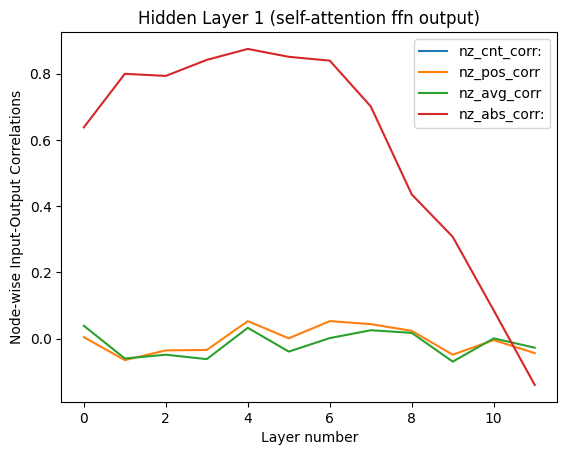

In [379]:
ffn_corr1_df.plot(xlabel="Layer number", ylabel= "Node-wise Input-Output Correlations",
             title="Hidden Layer 1 (self-attention ffn output)")

<AxesSubplot: title={'center': 'Hidden Layer 2 (intermediate dense ffn output)'}, xlabel='Layer number', ylabel='Node-wise Input-Output Correlations'>

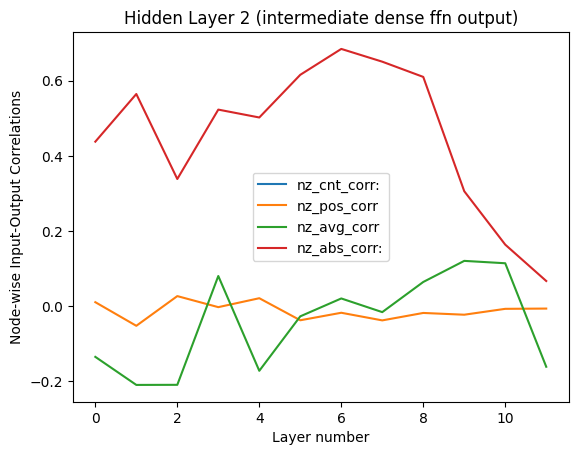

In [380]:
ffn_corr2_df.plot(xlabel="Layer number", ylabel= "Node-wise Input-Output Correlations",
             title="Hidden Layer 2 (intermediate dense ffn output)")

<AxesSubplot: title={'center': 'Element-wise correlations of self-attention weight matrices within layers'}, xlabel='Layer Number', ylabel='Correlation'>

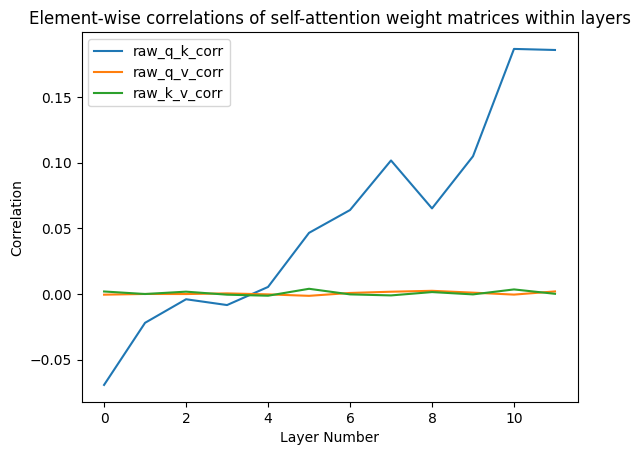

In [381]:
raw_corr_df[['raw_q_k_corr', 'raw_q_v_corr', 'raw_k_v_corr']].plot(xlabel="Layer Number",
                                                                    ylabel = "Correlation",
                                                                  title = "Element-wise correlations of self-attention weight matrices within layers")

<AxesSubplot: title={'center': 'Summary weight matrix column correlations'}, xlabel='Layer number', ylabel='Correlation'>

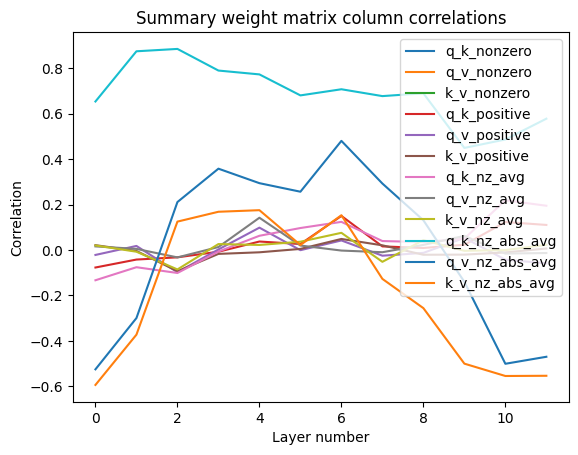

In [382]:
summ_attn_corr_in_df.loc[:, summ_attn_corr_in_df.columns!='layer_number'].plot(xlabel="Layer number", ylabel= "Correlation",
             title="Summary weight matrix column correlations")

<AxesSubplot: title={'center': 'Summary weight matrix rows correlations'}, xlabel='Layer number', ylabel='Correlation'>

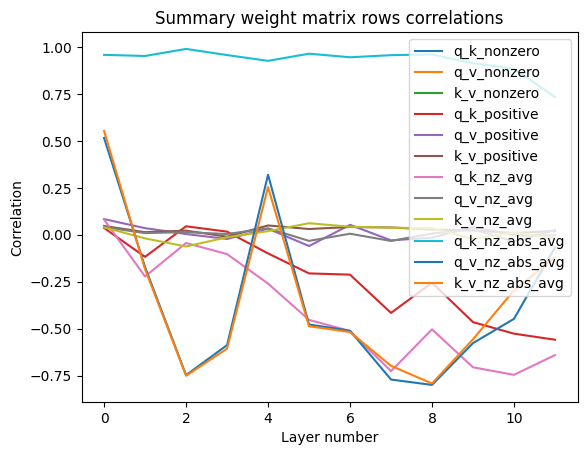

In [383]:
summ_attn_corr_out_df.loc[:, summ_attn_corr_out_df.columns!='layer_number'].plot(xlabel="Layer number", ylabel= "Correlation",
             title="Summary weight matrix rows correlations")

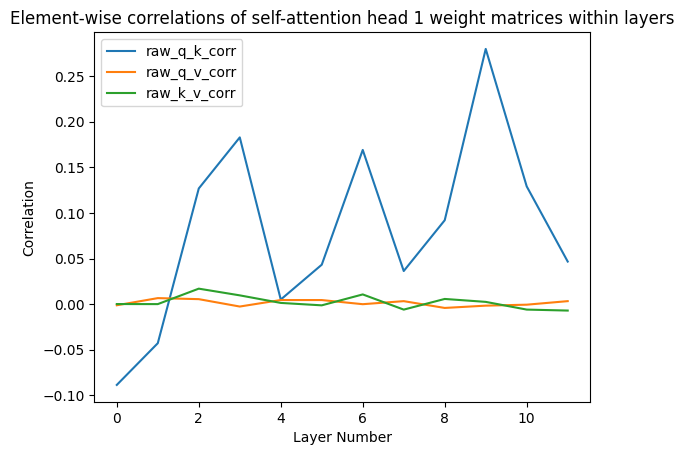

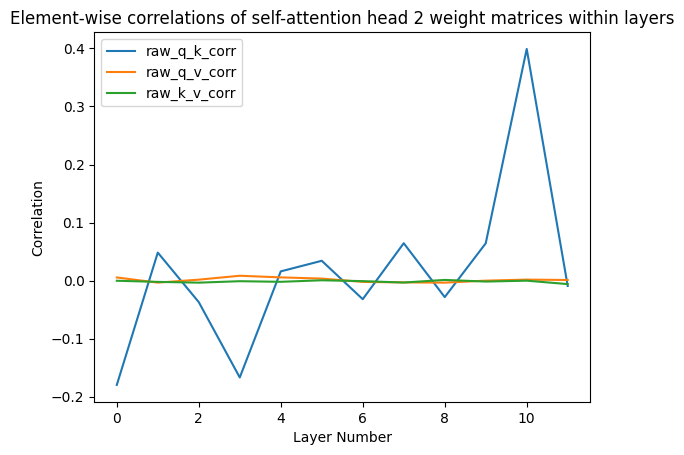

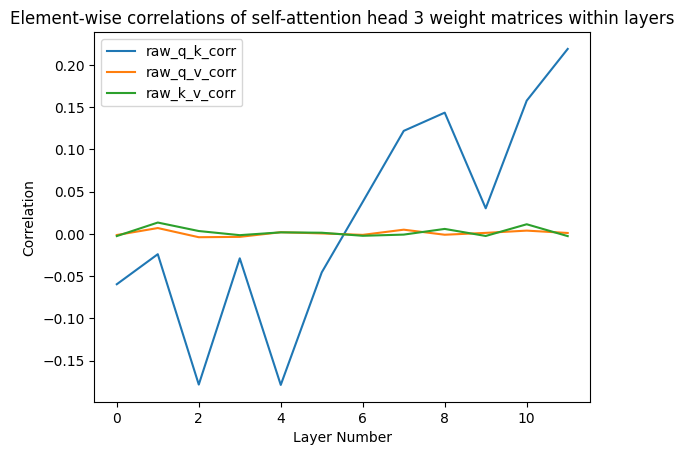

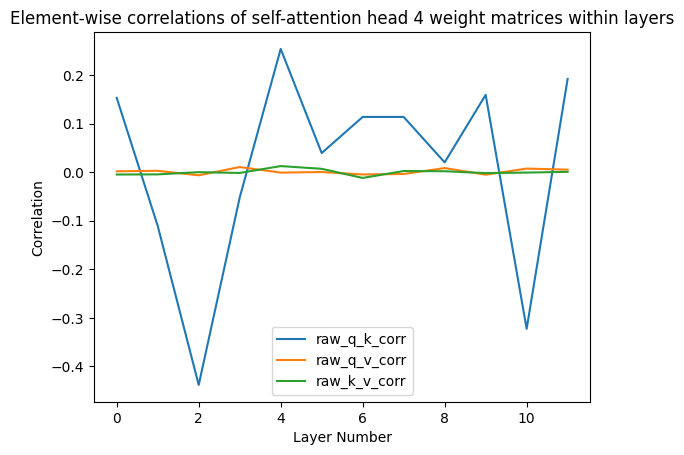

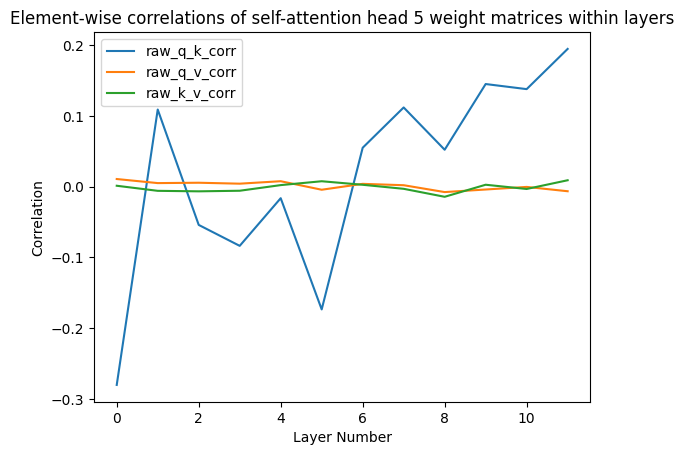

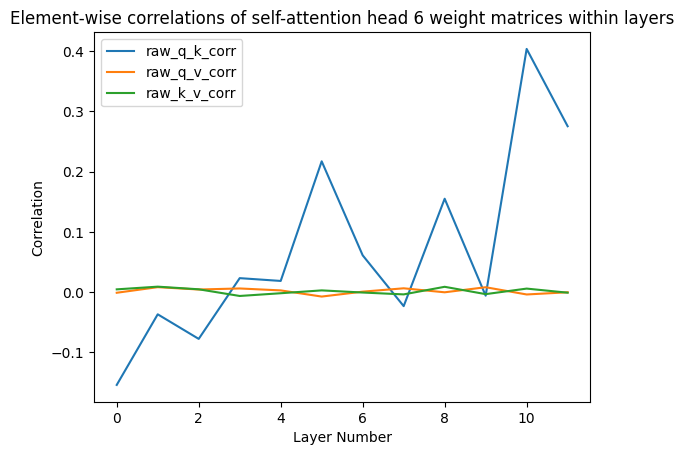

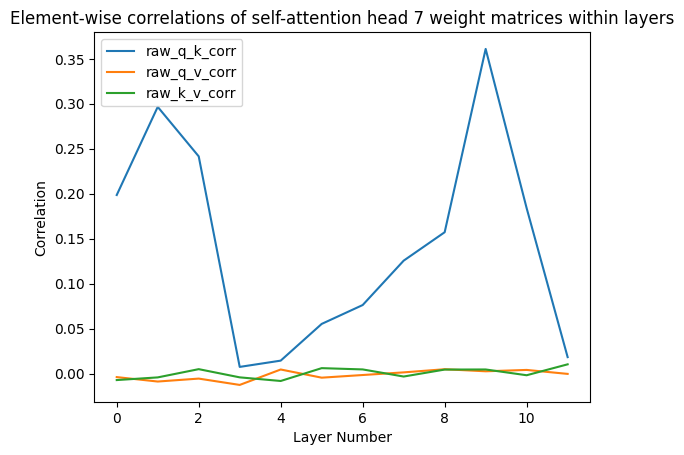

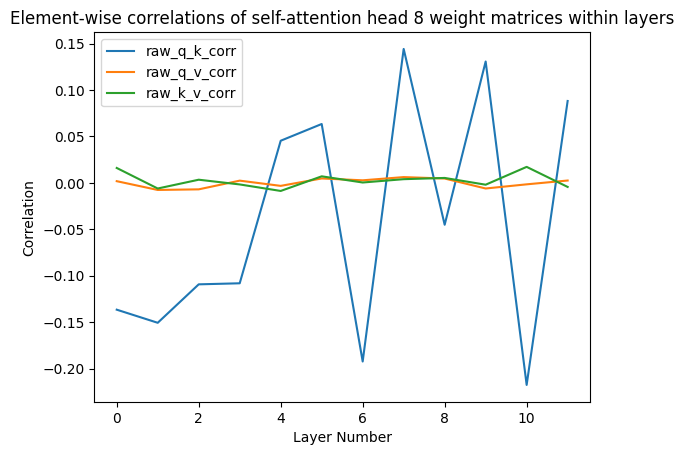

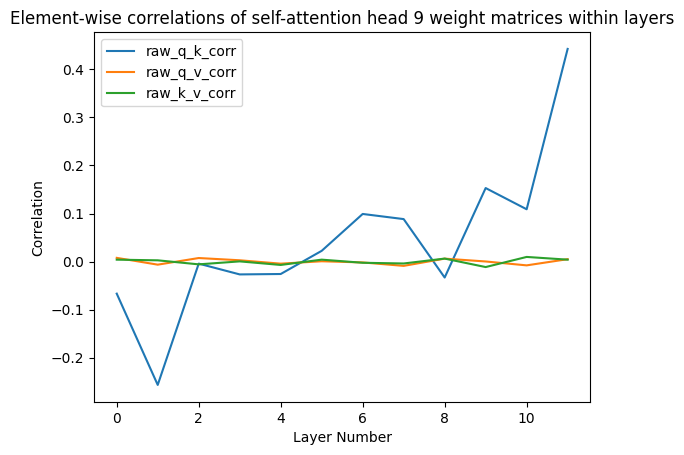

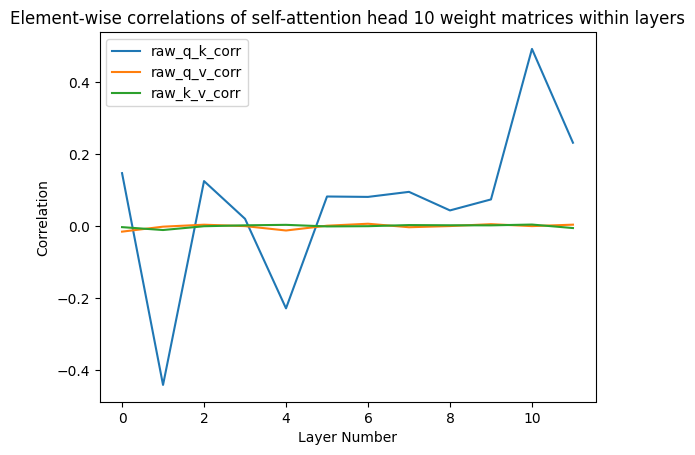

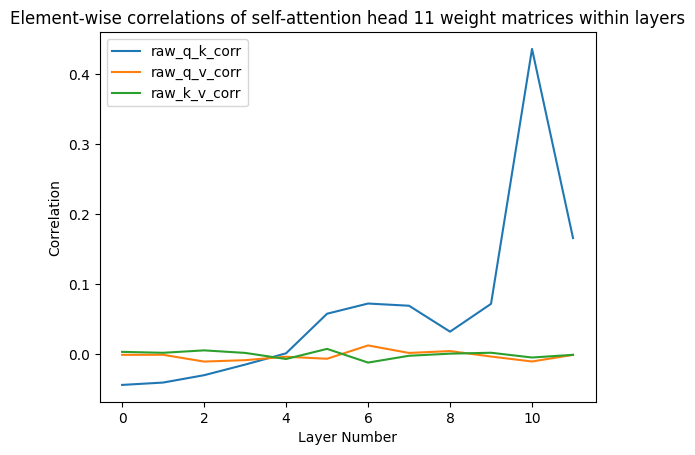

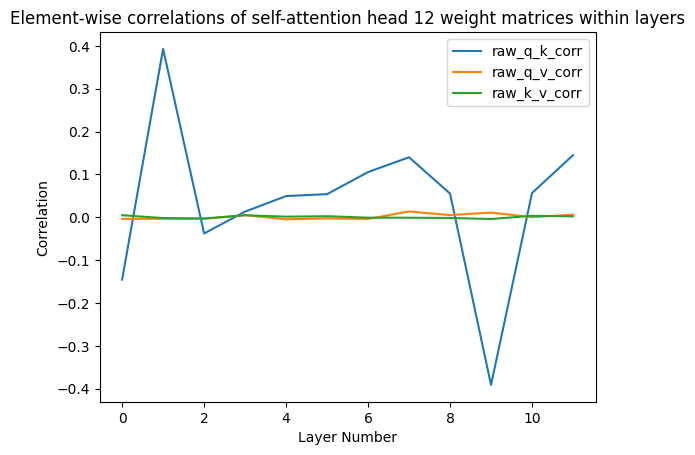

In [435]:
for layer_number in range(12):
    head_raw_corr_df[head_raw_corr_df['head_number'] == layer_number + 1].reset_index()\
        [['raw_q_k_corr', 'raw_q_v_corr', 'raw_k_v_corr']]\
        .plot(xlabel="Layer Number", ylabel = "Correlation",
              title = f"Element-wise correlations of self-attention head {layer_number + 1} weight matrices within layers")

In [436]:
head_raw_corr_df[head_raw_corr_df['head_number'] == 1].reset_index()

index layer_number  raw_q_k_corr  raw_q_v_corr  raw_k_v_corr head_number
0       0            1     -0.088619     -0.001253      0.000088           1
1      12            2     -0.042871      0.006587      0.000012           1
2      24            3      0.126840      0.005454      0.016961           1
3      36            4      0.182871     -0.002652      0.009609           1
4      48            5      0.005015      0.004480      0.001314           1
5      60            6      0.043235      0.004455     -0.001335           1
6      72            7      0.169101     -0.000081      0.010637           1
7      84            8      0.036294      0.003263     -0.006017           1
8      96            9      0.092002     -0.004191      0.005677           1
9     108           10      0.279888     -0.001678      0.002459           1
10    120           11      0.129105     -0.000623     -0.005995           1
11    132           12      0.046683      0.003265     -0.007069           1

In [358]:
summ_attn_corr_in_df

layer_number  q_k_nonzero  q_v_nonzero  k_v_nonzero  q_k_positive  \
0             0          NaN          NaN          NaN     -0.077194   
1             1          NaN          NaN          NaN     -0.042174   
2             2          NaN          NaN          NaN     -0.032369   
3             3          NaN          NaN          NaN     -0.007716   
4             4          NaN          NaN          NaN      0.037206   
5             5          NaN          NaN          NaN      0.026163   
6             6          NaN          NaN          NaN      0.149856   
7             7          NaN          NaN          NaN      0.015793   
8             8          NaN          NaN          NaN      0.008793   
9             9          NaN          NaN          NaN      0.022843   
10           10          NaN          NaN          NaN      0.122992   
11           11          NaN          NaN          NaN      0.110208   

    q_v_positive  k_v_positive  q_k_nz_avg  q_v_nz_avg  k_v_nz_avg  \
0      -0.021836      0.021214   -0.133339    0.015735    0.019955   
1       0.017779     -0.004297   -0.075881    0.004774   -0.007640   
2      -0.098005     -0.093616   -0.101334   -0.032742   -0.085706   
3       0.002287     -0.017254   -0.006992    0.012997    0.025996   
4       0.098249     -0.010221    0.062491    0.141939    0.022125   
5      -0.000936      0.004658    0.096647    0.019543    0.036311   
6       0.041946      0.048500    0.123771   -0.002567    0.075529   
7      -0.025179      0.020459    0.039325   -0.009888   -0.052119   
8      -0.012836     -0.021032    0.034820    0.022345    0.043099   
9       0.053350     -0.020498    0.050030    0.061991   -0.003558   
10     -0.042816     -0.010777    0.218834   -0.015796   -0.000581   
11     -0.058753      0.006478    0.194732   -0.013424    0.022687   

    q_k_nz_abs_avg  q_v_nz_abs_avg  k_v_nz_abs_avg  
0         0.653695       -0.525438       -0.594081  
1         0.874697       -0.299742       -0.372824  
2         0.885100        0.211018        0.124866  
3         0.789868        0.357893        0.168227  
4         0.772931        0.294091        0.175192  
5         0.680500        0.256491        0.021830  
6         0.707538        0.480310        0.152977  
7         0.677398        0.292501       -0.127279  
8         0.689744        0.130777       -0.256048  
9         0.449279       -0.140247       -0.500423  
10        0.486458       -0.500980       -0.554774  
11        0.577955       -0.470171       -0.553815

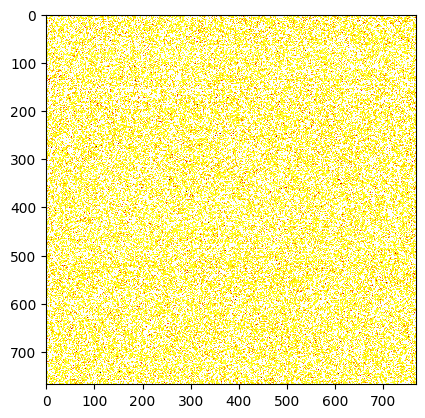

In [385]:
#array_heatmap(model.encoder.layer[5].attention.self.query.weight.data.numpy())
plt.imshow(model.encoder.layer[5].attention.self.query.weight.data.numpy(),
           cmap='hot', norm='log')

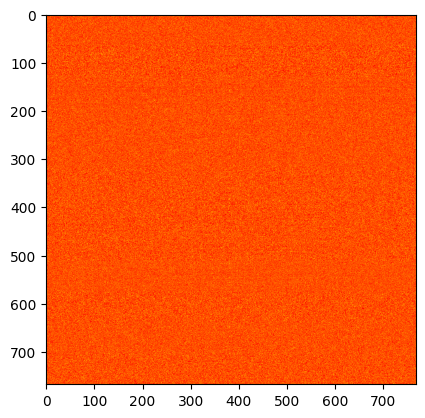

In [387]:
plt.imshow(model.encoder.layer[5].attention.self.query.weight.data.numpy(),
           cmap='hot')

In [203]:
corr1_df

nz_cnt_corr:  nz_pos_corr  nz_avg_corr  nz_abs_corr:
0            NaN     0.004421     0.038784      0.637911
1            NaN    -0.064968    -0.060069      0.799651
2            NaN    -0.035601    -0.048637      0.793365
3            NaN    -0.034231    -0.062037      0.841767
4            NaN     0.052765     0.032590      0.874866
5            NaN     0.000944    -0.039209      0.851028
6            NaN     0.052725     0.001506      0.839517
7            NaN     0.043703     0.025230      0.701192
8            NaN     0.023432     0.017317      0.435337
9            NaN    -0.048618    -0.069571      0.307392
10           NaN    -0.004458     0.000724      0.085010
11           NaN    -0.043883    -0.027492     -0.139899

In [208]:
in_df, out_df = compute_basic_weight_stats(model.encoder.layer[0].attention.self.query.weight.data.numpy())
compute_basic_weight_stats(model.encoder.layer[0].attention.self.query.weight.data.numpy())

(     nonzero  positive    nz_avg  nz_abs_avg
 0        768       361 -0.002436    0.033115
 1        768       379  0.000741    0.036338
 2        768       374 -0.000108    0.034288
 3        768       414  0.002157    0.033830
 4        768       383 -0.001291    0.031552
 ..       ...       ...       ...         ...
 763      768       380 -0.001853    0.032164
 764      768       376 -0.000903    0.031813
 765      768       387  0.002580    0.035710
 766      768       388 -0.000008    0.033744
 767      768       368 -0.001511    0.030804
 
 [768 rows x 4 columns],
      nonzero  positive    nz_avg  nz_abs_avg
 0        768       387  0.001150    0.030071
 1        768       380 -0.000028    0.028454
 2        768       386  0.000243    0.027993
 3        768       376  0.000051    0.029696
 4        768       351 -0.002309    0.030423
 ..       ...       ...       ...         ...
 763      768       378 -0.000011    0.038883
 764      768       379  0.000582    0.038900
 765   

In [209]:
in_df

nonzero  positive    nz_avg  nz_abs_avg
0        768       361 -0.002436    0.033115
1        768       379  0.000741    0.036338
2        768       374 -0.000108    0.034288
3        768       414  0.002157    0.033830
4        768       383 -0.001291    0.031552
..       ...       ...       ...         ...
763      768       380 -0.001853    0.032164
764      768       376 -0.000903    0.031813
765      768       387  0.002580    0.035710
766      768       388 -0.000008    0.033744
767      768       368 -0.001511    0.030804

[768 rows x 4 columns]

In [213]:
out_df

nonzero  positive    nz_avg  nz_abs_avg
0        768       387  0.001150    0.030071
1        768       380 -0.000028    0.028454
2        768       386  0.000243    0.027993
3        768       376  0.000051    0.029696
4        768       351 -0.002309    0.030423
..       ...       ...       ...         ...
763      768       378 -0.000011    0.038883
764      768       379  0.000582    0.038900
765      768       400  0.001030    0.039724
766      768       377 -0.000421    0.040635
767      768       388  0.000586    0.032753

[768 rows x 4 columns]

In [259]:
raw

layer_number  raw_q_k_corr  raw_q_v_corr  raw_k_v_corr
0             0     -0.069268     -0.000548      0.001877

In [240]:
summ_in.keys()

dict_keys(['q_k_nonzero', 'q_v_nonzero', 'k_v_nonzero', 'q_k_positive', 'q_v_positive', 'k_v_positive', 'q_k_nz_avg', 'q_v_nz_avg', 'k_v_nz_avg', 'q_k_nz_abs_avg', 'q_v_nz_abs_avg', 'k_v_nz_abs_avg'])

In [235]:
summ_out

{'q_k_nonzero': nan,
 'q_v_nonzero': nan,
 'k_v_nonzero': nan,
 'q_k_positive': -0.09943355601508828,
 'q_v_positive': 0.032252854583220636,
 'k_v_positive': 0.04953682543059331,
 'q_k_nz_avg': -0.2601483960099225,
 'q_v_nz_avg': 0.034427465871539026,
 'k_v_nz_avg': 0.01911665503887739,
 'q_k_nz_abs_avg': 0.9264313577468221,
 'q_v_nz_abs_avg': 0.3198364619286835,
 'k_v_nz_abs_avg': 0.25384954254233744}

In [279]:
summ_att_corr_out_df

layer_number q_k_nonzero q_v_nonzero k_v_nonzero  q_k_positive  \
0           11.0         NaN         NaN         NaN     -0.559180   
1            0.0         NaN         NaN         NaN      0.036017   
2            1.0         NaN         NaN         NaN     -0.117659   
3            2.0         NaN         NaN         NaN      0.045163   
4            3.0         NaN         NaN         NaN      0.016550   
5            4.0         NaN         NaN         NaN     -0.099434   
6            5.0         NaN         NaN         NaN     -0.205849   
7            6.0         NaN         NaN         NaN     -0.212544   
8            7.0         NaN         NaN         NaN     -0.416425   
9            8.0         NaN         NaN         NaN     -0.255267   
10           9.0         NaN         NaN         NaN     -0.465477   
11          10.0         NaN         NaN         NaN     -0.526949   
12          11.0         NaN         NaN         NaN     -0.559180   

    q_v_positive  k_v_positive  q_k_nz_avg  q_v_nz_avg  k_v_nz_avg  \
0      -0.003659      0.020167   -0.641019    0.025290   -0.019847   
1       0.083406      0.046556    0.080566    0.040270    0.039092   
2       0.035123      0.013699   -0.222405    0.008860   -0.019370   
3       0.003831      0.022013   -0.043940    0.013768   -0.062609   
4      -0.022515     -0.010392   -0.103086    0.003962   -0.013387   
5       0.032253      0.049537   -0.260148    0.034427    0.019117   
6      -0.060037      0.030577   -0.453507   -0.032683    0.061549   
7       0.052842      0.041304   -0.512895    0.005524    0.042641   
8      -0.029884      0.038841   -0.726455   -0.032947    0.037436   
9      -0.015427      0.027641   -0.503980    0.006477    0.034622   
10      0.041978      0.022629   -0.706058    0.029936   -0.022598   
11     -0.002412      0.009130   -0.746280   -0.036703    0.011943   
12     -0.003659      0.020167   -0.641019    0.025290   -0.019847   

    q_k_nz_abs_avg  q_v_nz_abs_avg  k_v_nz_abs_avg  
0         0.733672       -0.067769       -0.119423  
1         0.958285        0.515858        0.552959  
2         0.952397       -0.172277       -0.183412  
3         0.989962       -0.747906       -0.751140  
4         0.957226       -0.587902       -0.606910  
5         0.926431        0.319836        0.253850  
6         0.964551       -0.478160       -0.487432  
7         0.945515       -0.511158       -0.518339  
8         0.956647       -0.771421       -0.698201  
9         0.960730       -0.799967       -0.792409  
10        0.913656       -0.577196       -0.556818  
11        0.884381       -0.447888       -0.296087  
12        0.733672       -0.067769       -0.119423

In [270]:
summ_in

{'q_k_nonzero': nan,
 'q_v_nonzero': nan,
 'k_v_nonzero': nan,
 'q_k_positive': 0.11020808495449412,
 'q_v_positive': -0.05875328055151076,
 'k_v_positive': 0.006477537098235878,
 'q_k_nz_avg': 0.19473182135156927,
 'q_v_nz_avg': -0.013423716660909534,
 'k_v_nz_avg': 0.022687471031133416,
 'q_k_nz_abs_avg': 0.5779548442252872,
 'q_v_nz_abs_avg': -0.4701705330259239,
 'k_v_nz_abs_avg': -0.5538153552946302,
 'layer_number': 11}

In [377]:
check_bert_layer_sparsity(model, 7)

Sparsity in layer 7 ffn output: 0.00%


### Sparsity analysis

In [388]:
prune_bert_layers(model, 0.5) # pruning is done in place

In [367]:
check_bert_layer_sparsity(model, 7)

Sparsity in layer 7 ffn output: 50.00%


Feed-Forward Node Input/Output Correlations for layer 0:
Hidden layer 1:
    nz_cnt_corr: 0.653 
    nz_pos_corr: -0.016
    nz_avg_corr: 0.019
    nz_abs_corr: 0.609
    
Hidden layer 2:
    nz_cnt_corr: 0.506 
    nz_pos_corr: -0.052
    nz_avg_corr: -0.048
    nz_abs_corr: 0.403
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 1:
Hidden layer 1:
    nz_cnt_corr: 0.759 
    nz_pos_corr: -0.050
    nz_avg_corr: -0.048
    nz_abs_corr: 0.797
    
Hidden layer 2:
    nz_cnt_corr: 0.599 
    nz_pos_corr: -0.028
    nz_avg_corr: -0.092
    nz_abs_corr: 0.559
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 2:
Hidden layer 1:
    nz_cnt_corr: 0.773 
    nz_pos_corr: -0.035
    nz_avg_corr: -0.044
    nz_abs_corr: 0.772
    
Hidden layer 2:
    nz_cnt_corr: 0.496 
    nz_pos_corr: -0.009
    nz_avg_corr: -0.073
    nz_abs_corr: 0.682
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: 

Feed-Forward Node Input/Output Correlations for layer 3:
Hidden layer 1:
    nz_cnt_corr: 0.745 
    nz_pos_corr: -0.059
    nz_avg_corr: -0.066
    nz_abs_corr: 0.835
    
Hidden layer 2:
    nz_cnt_corr: 0.574 
    nz_pos_corr: -0.002
    nz_avg_corr: 0.090
    nz_abs_corr: 0.611
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 4:
Hidden layer 1:
    nz_cnt_corr: 0.737 
    nz_pos_corr: 0.046
    nz_avg_corr: 0.040
    nz_abs_corr: 0.853
    
Hidden layer 2:
    nz_cnt_corr: 0.558 
    nz_pos_corr: 0.037
    nz_avg_corr: -0.053
    nz_abs_corr: 0.458
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 5:
Hidden layer 1:
    nz_cnt_corr: 0.653 
    nz_pos_corr: -0.004
    nz_avg_corr: -0.040
    nz_abs_corr: 0.822
    
Hidden layer 2:
    nz_cnt_corr: 0.607 
    nz_pos_corr: 0.016
    nz_avg_corr: -0.017
    nz_abs_corr: 0.598
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 6:
Hidden layer 1:
    nz_cnt_corr: 0.697 
    nz_pos_corr: 0.013
    nz_avg_corr: -0.008
    nz_abs_corr: 0.796
    
Hidden layer 2:
    nz_cnt_corr: 0.658 
    nz_pos_corr: 0.005
    nz_avg_corr: -0.058
    nz_abs_corr: 0.660
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 7:
Hidden layer 1:
    nz_cnt_corr: 0.654 
    nz_pos_corr: 0.001
    nz_avg_corr: 0.004
    nz_abs_corr: 0.660
    
Hidden layer 2:
    nz_cnt_corr: 0.596 
    nz_pos_corr: -0.038
    nz_avg_corr: -0.020
    nz_abs_corr: 0.648
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 8:
Hidden layer 1:
    nz_cnt_corr: 0.477 
    nz_pos_corr: 0.041
    nz_avg_corr: 0.020
    nz_abs_corr: 0.435
    
Hidden layer 2:
    nz_cnt_corr: 0.580 
    nz_pos_corr: -0.055
    nz_avg_corr: 0.087
    nz_abs_corr: 0.603
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 9:
Hidden layer 1:
    nz_cnt_corr: 0.366 
    nz_pos_corr: -0.053
    nz_avg_corr: -0.070
    nz_abs_corr: 0.219
    
Hidden layer 2:
    nz_cnt_corr: 0.462 
    nz_pos_corr: -0.014
    nz_avg_corr: 0.038
    nz_abs_corr: 0.654
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 10:
Hidden layer 1:
    nz_cnt_corr: 0.180 
    nz_pos_corr: -0.000
    nz_avg_corr: -0.004
    nz_abs_corr: -0.188
    
Hidden layer 2:
    nz_cnt_corr: 0.229 
    nz_pos_corr: -0.009
    nz_avg_corr: 0.029
    nz_abs_corr: 0.763
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


Feed-Forward Node Input/Output Correlations for layer 11:
Hidden layer 1:
    nz_cnt_corr: -0.130 
    nz_pos_corr: -0.007
    nz_avg_corr: -0.013
    nz_abs_corr: -0.186
    
Hidden layer 2:
    nz_cnt_corr: 0.055 
    nz_pos_corr: -0.021
    nz_avg_corr: -0.104
    nz_abs_corr: 0.219
    


/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:224: RuntimeWarning: invalid value encountered in divide
  nz_avg_outgoing = (param_array.sum(axis=0)) / nonzero_outgoing
/Users/colevincentfrank/Documents/Documents_Macbook_Air_2021_cvf/Coursework/MSCAPP/2022_Fall/deep_learning_systems/lottery-ticket/src/analyze_bert_base.py:229: RuntimeWarning: invalid value encountered in divide
  nz_abs_avg_outgoing = (np.abs(param_array).sum(axis=0)) / nonzero_outgoing


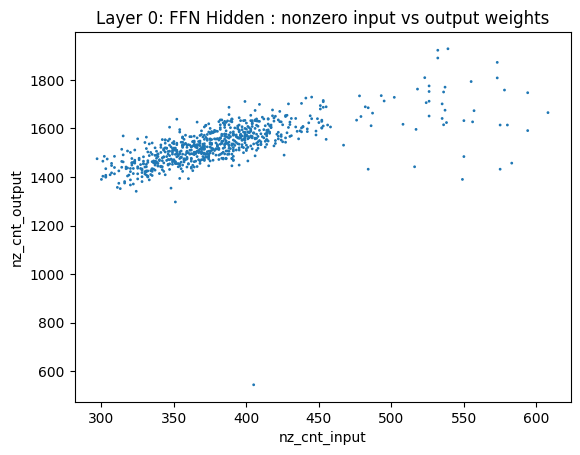

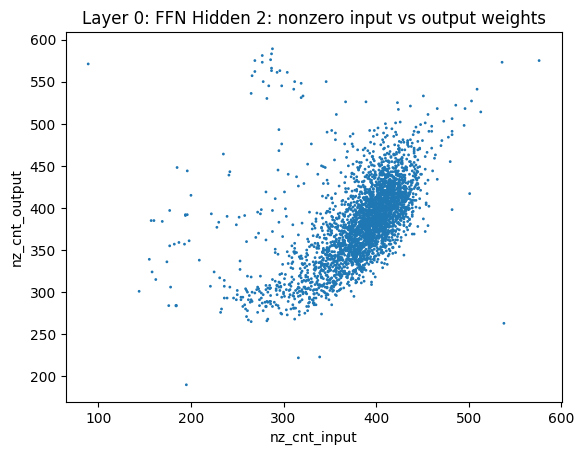

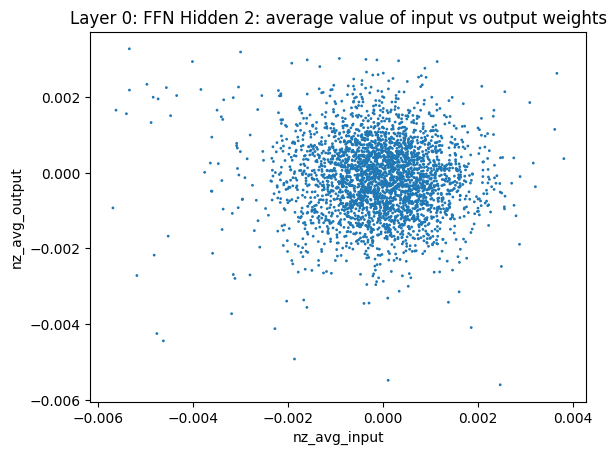

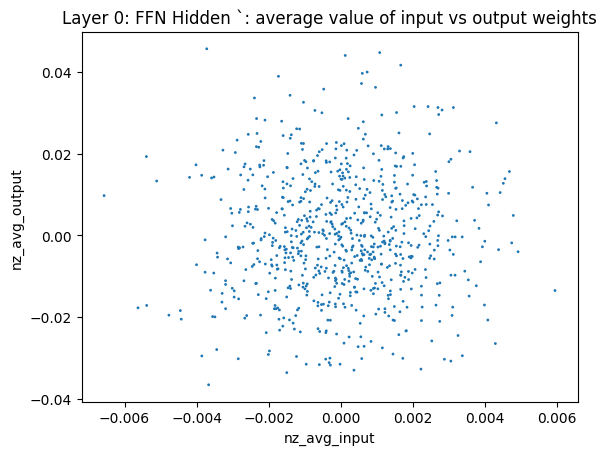

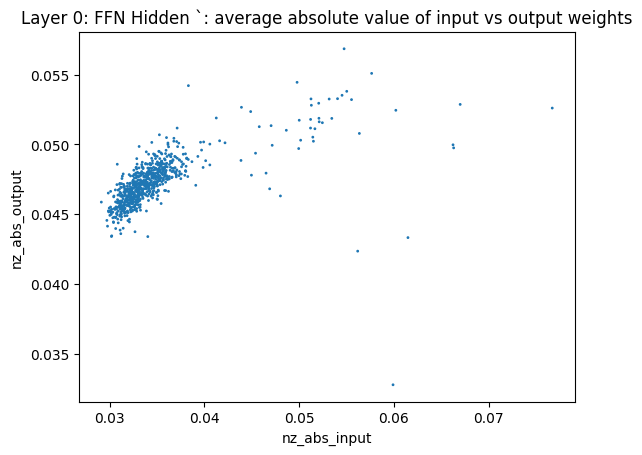

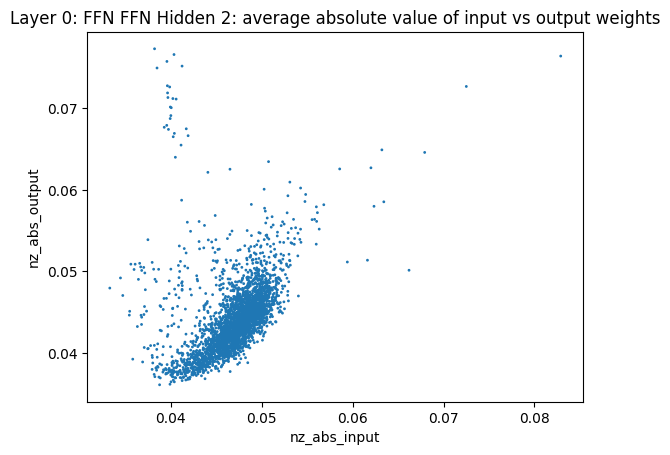

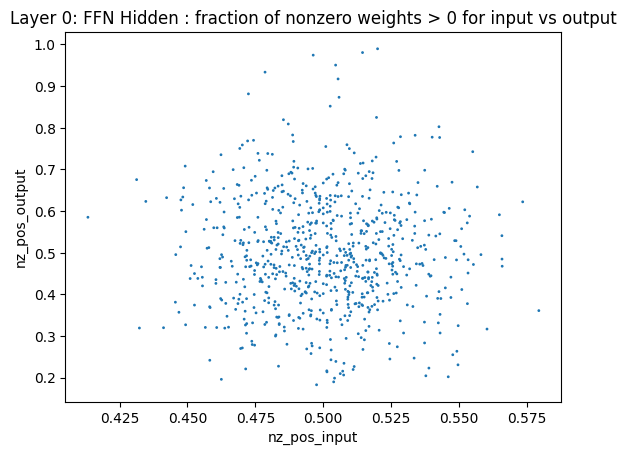

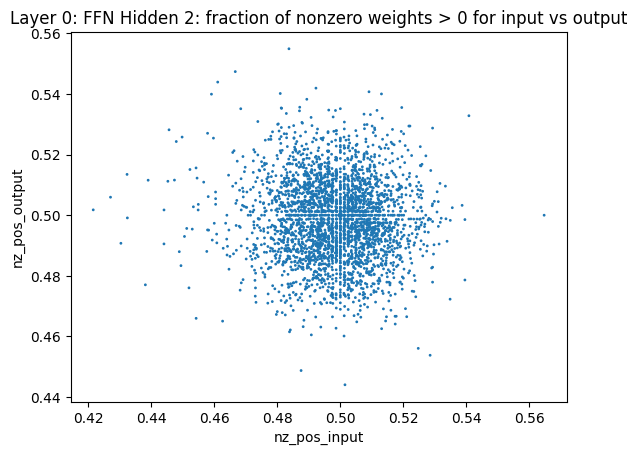

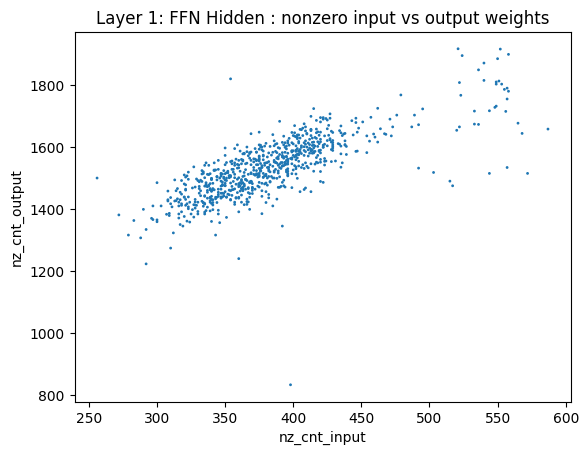

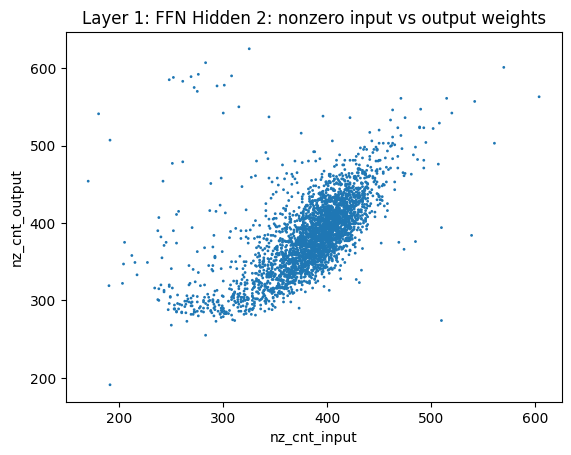

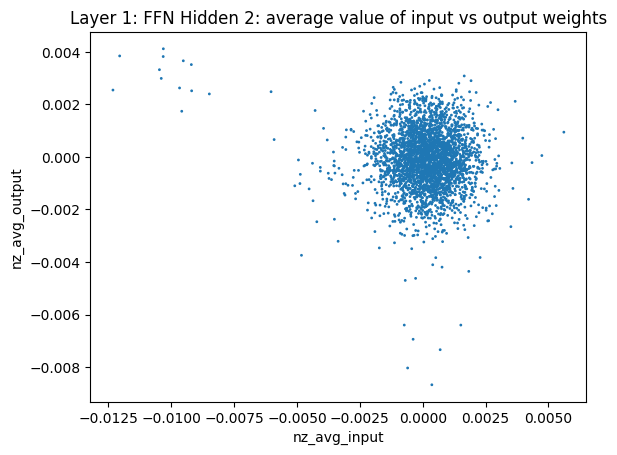

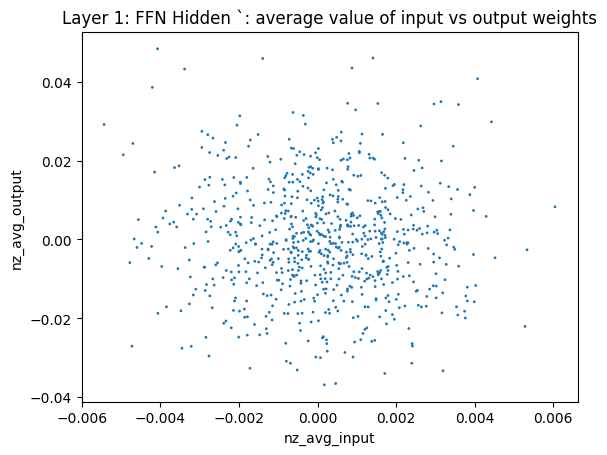

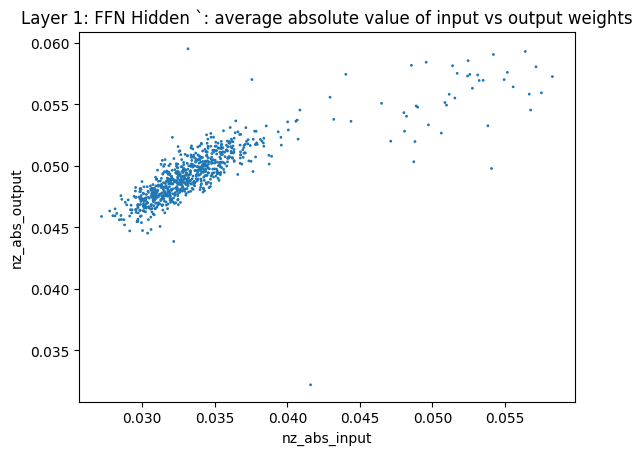

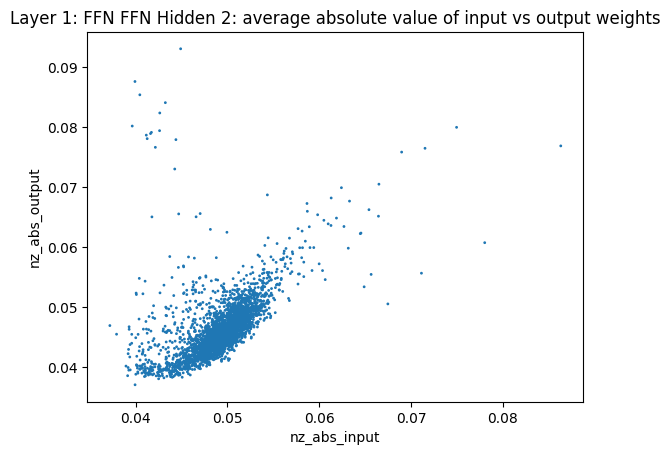

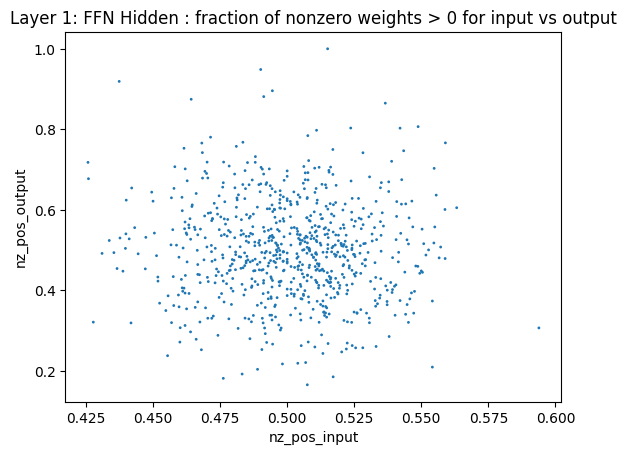

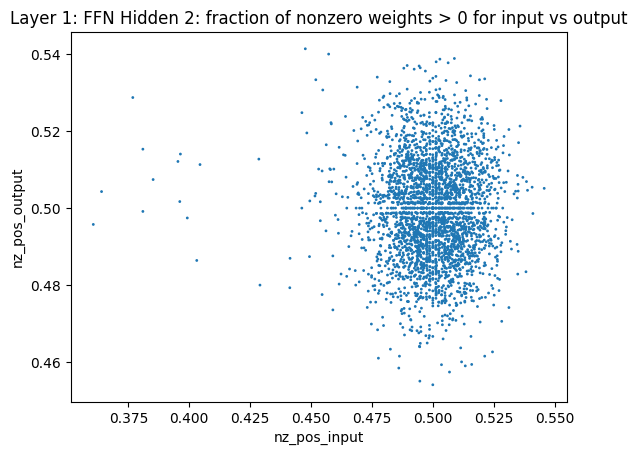

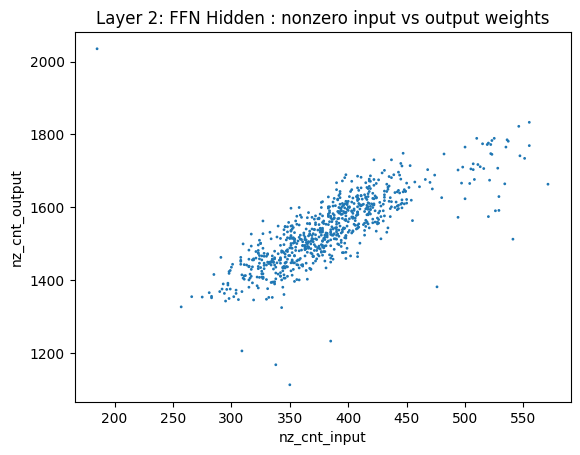

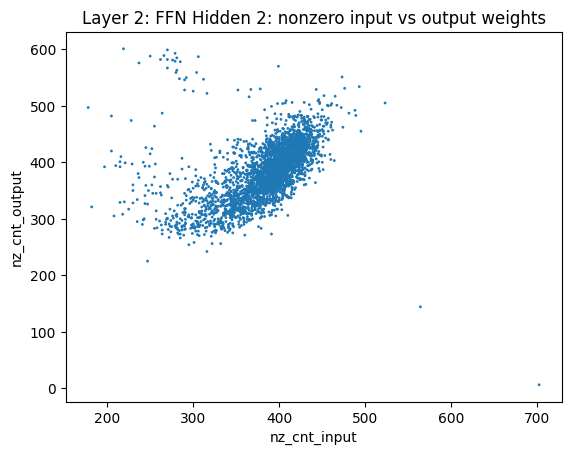

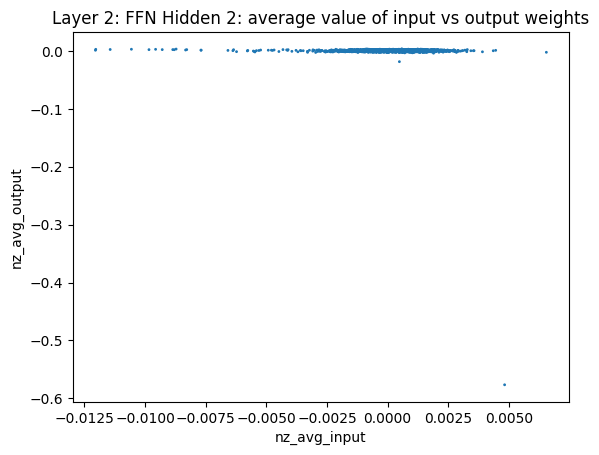

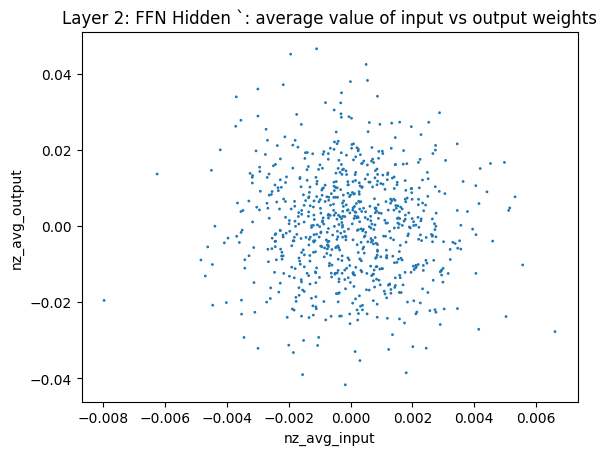

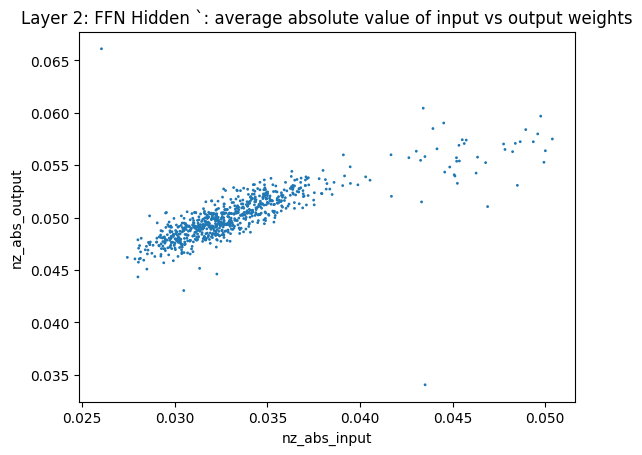

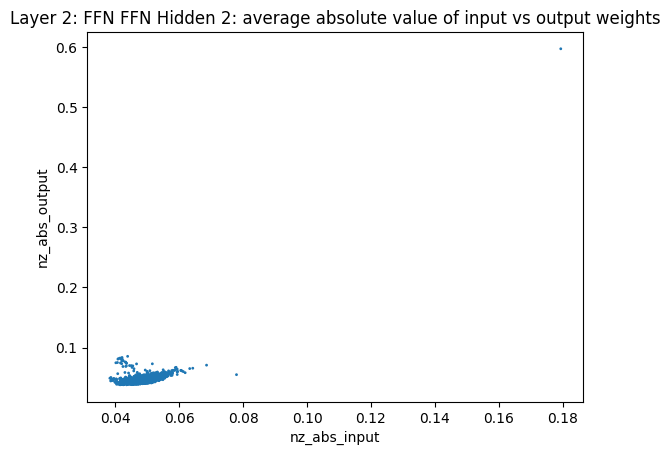

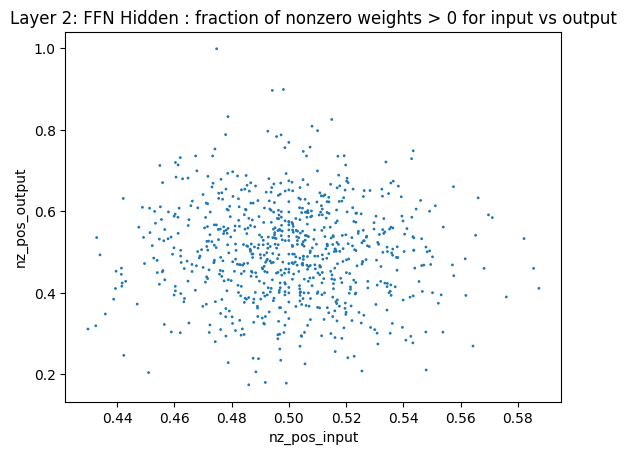

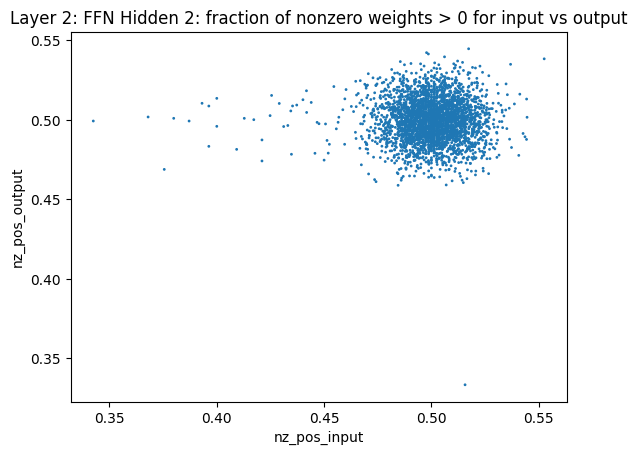

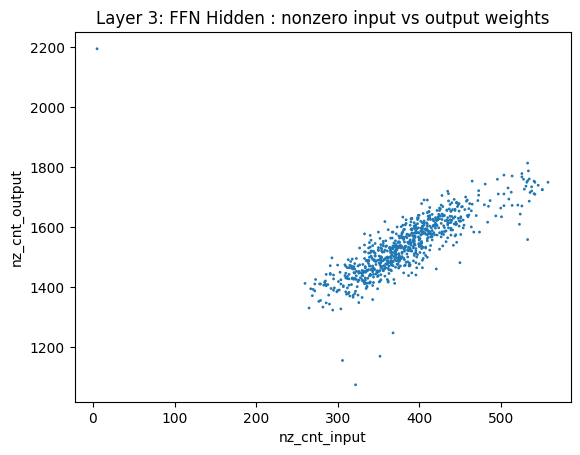

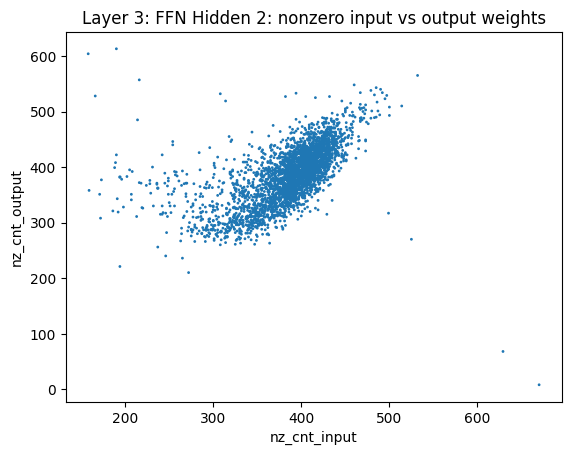

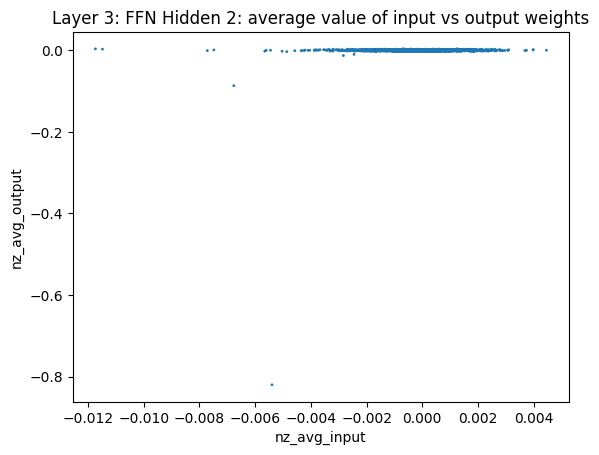

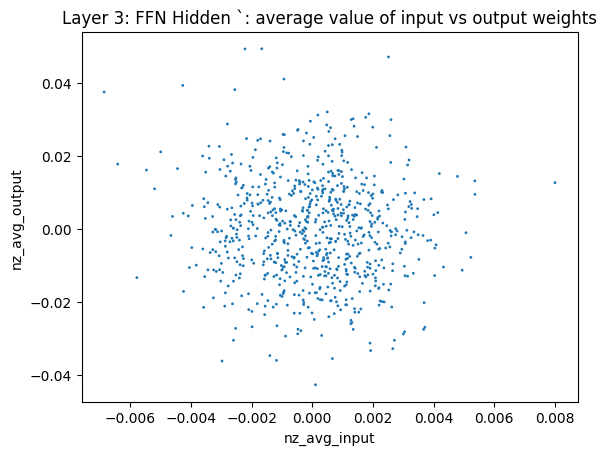

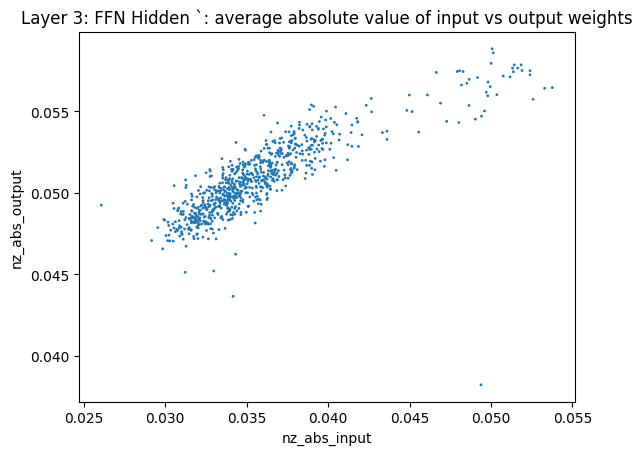

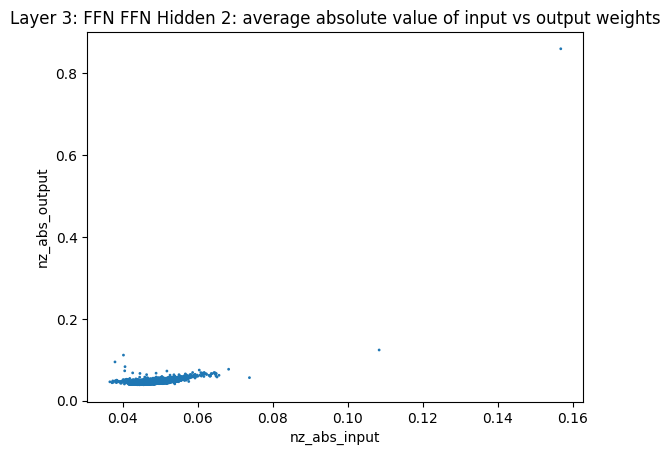

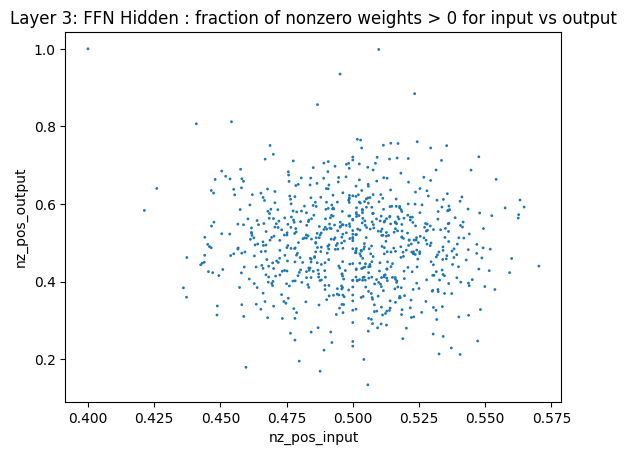

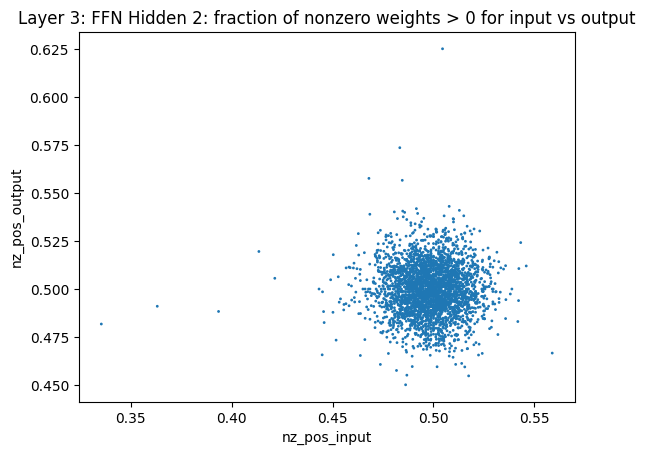

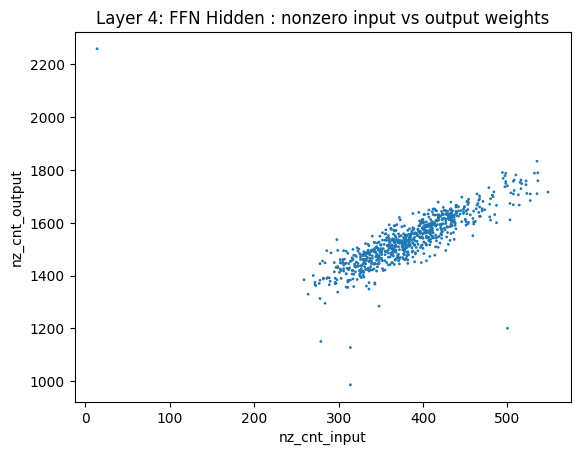

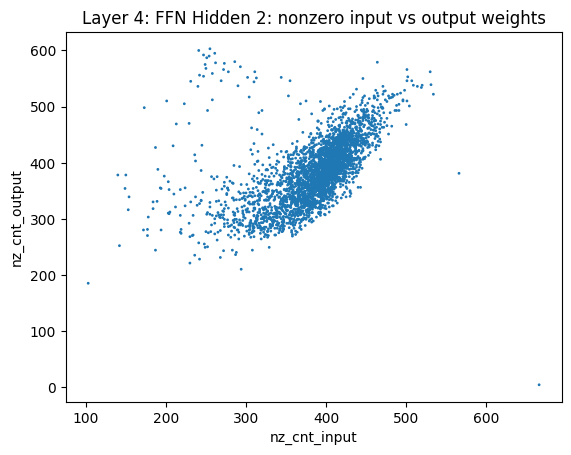

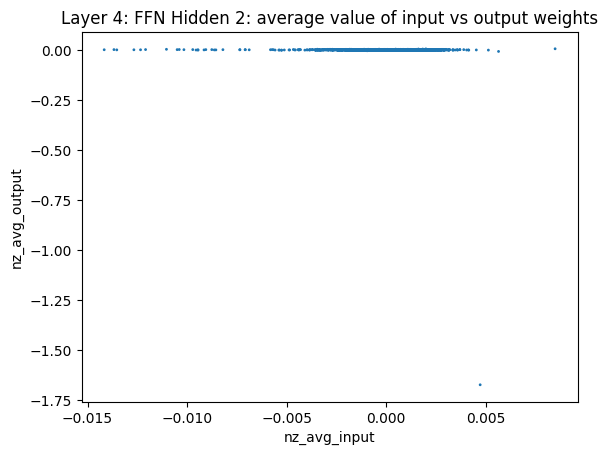

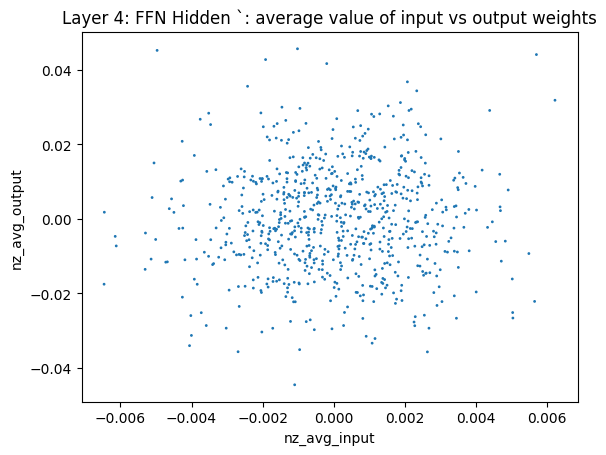

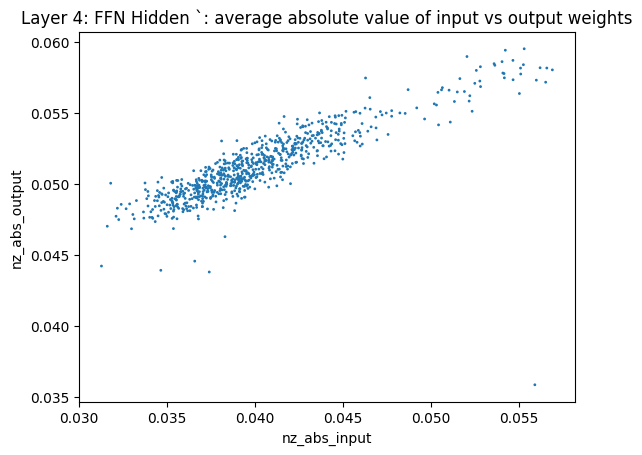

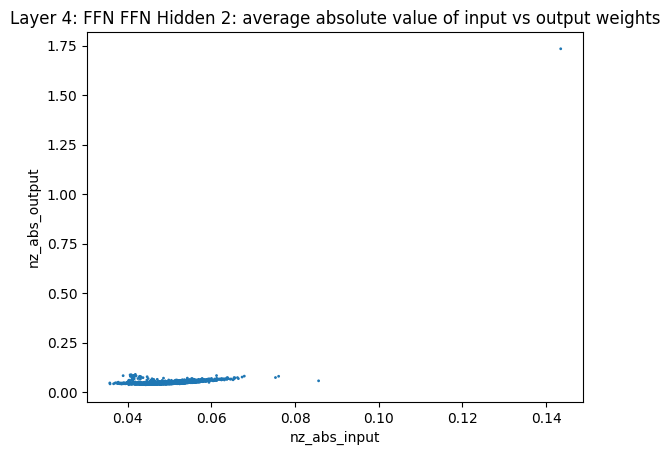

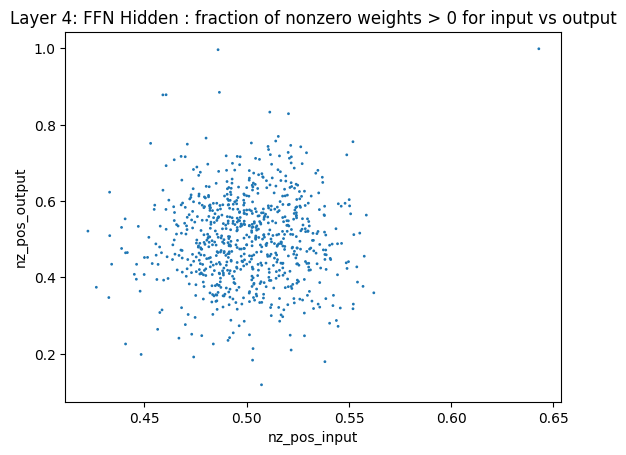

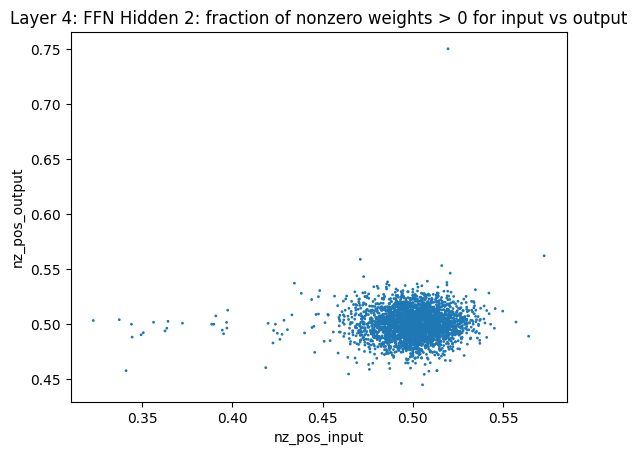

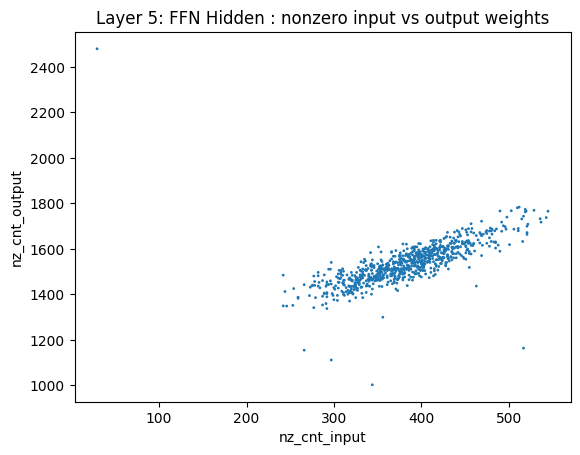

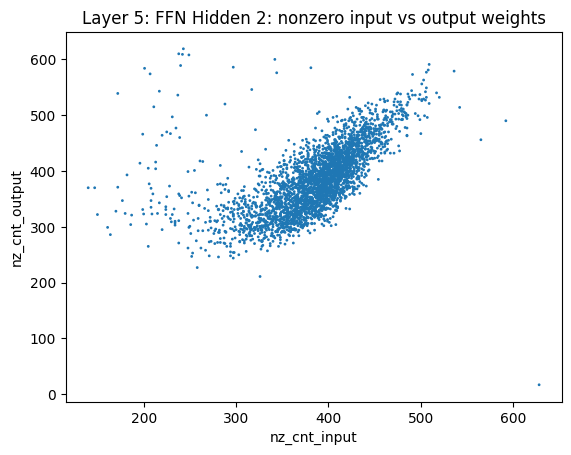

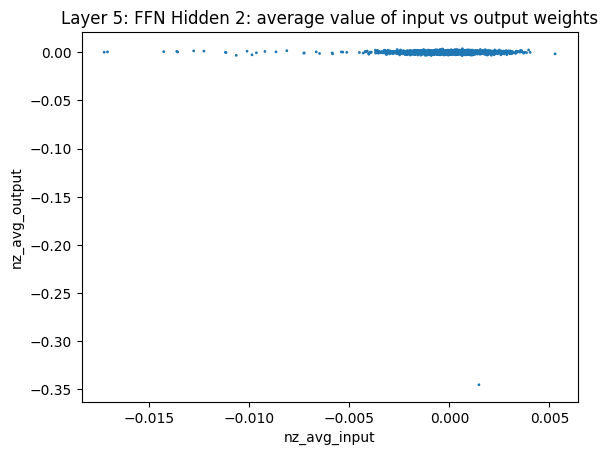

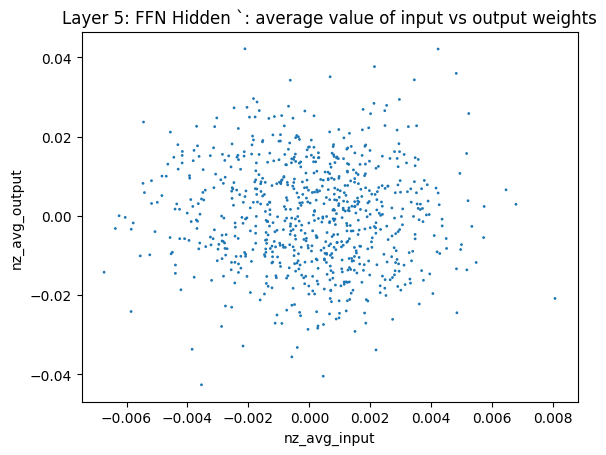

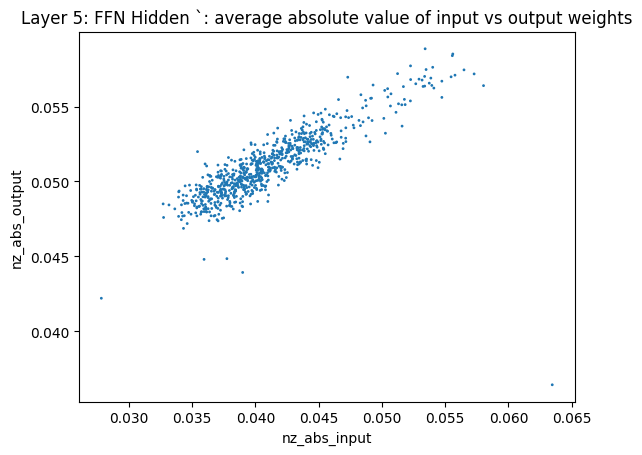

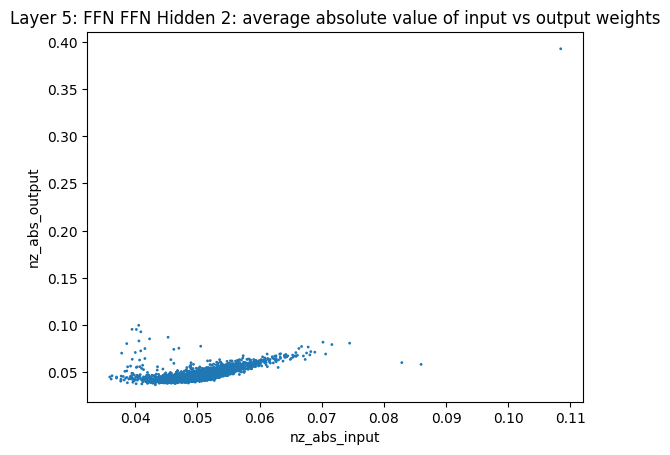

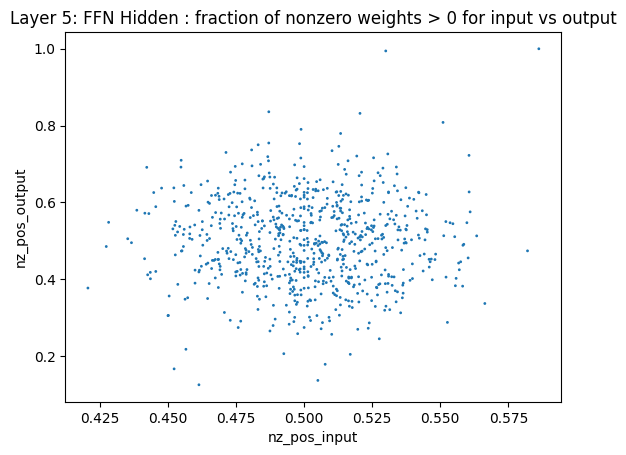

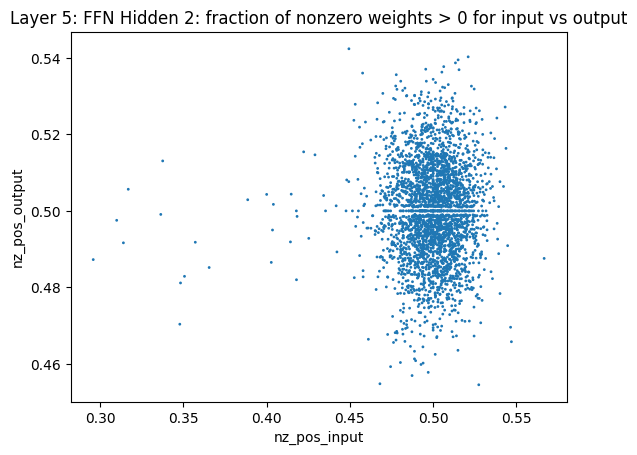

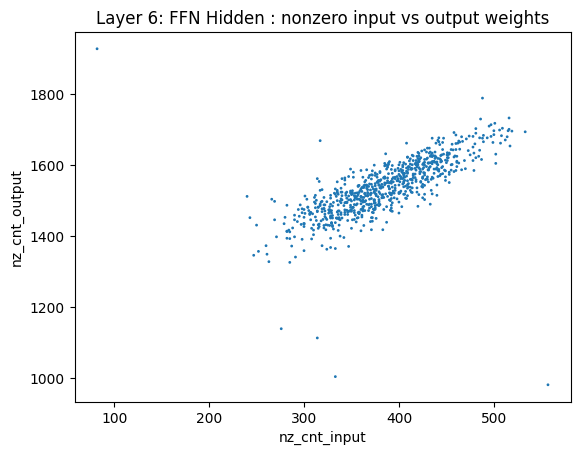

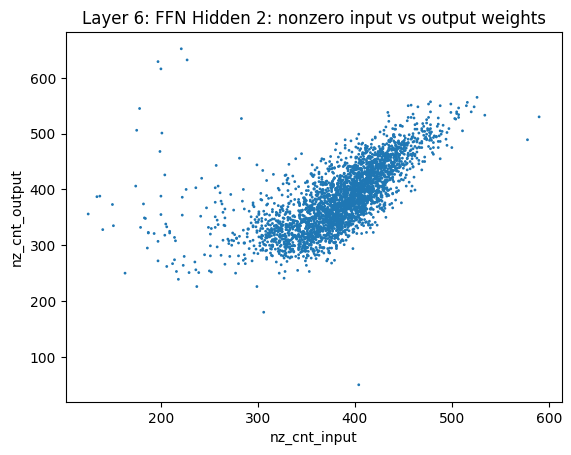

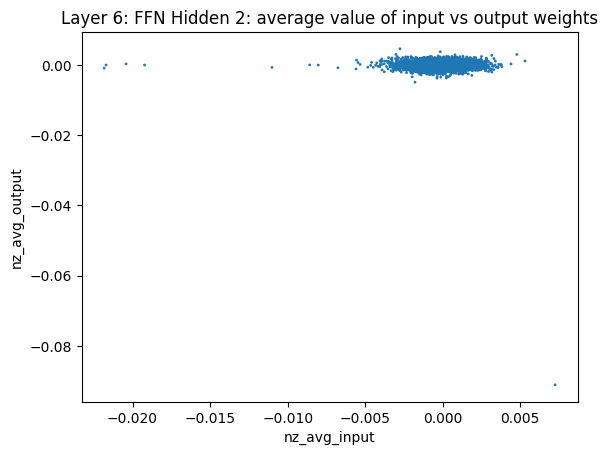

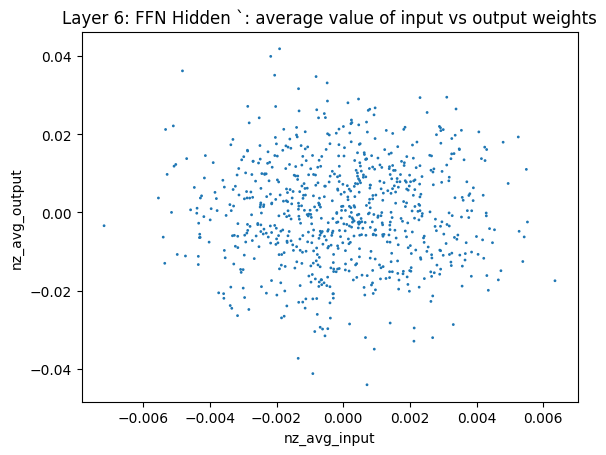

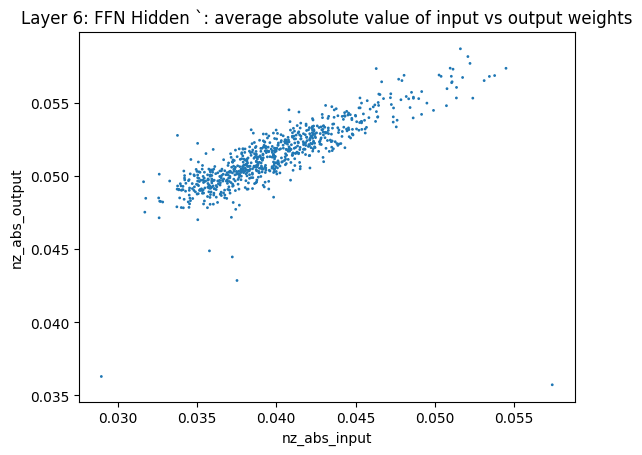

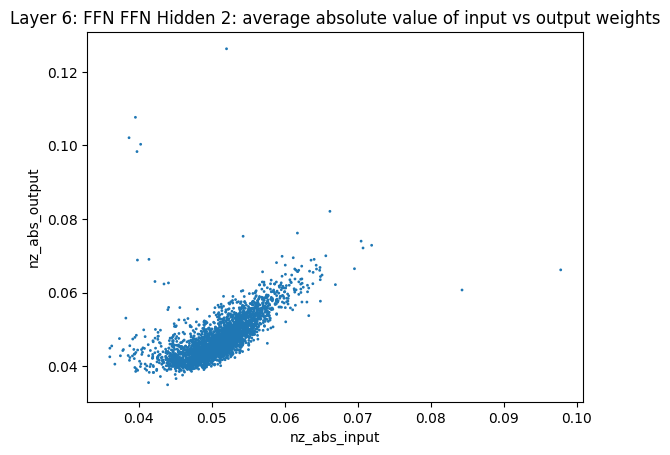

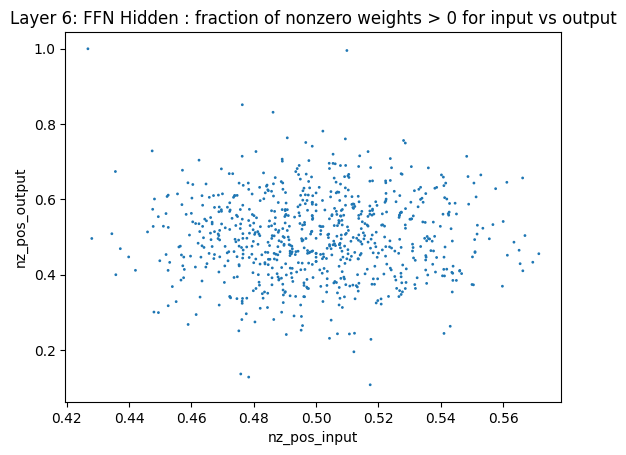

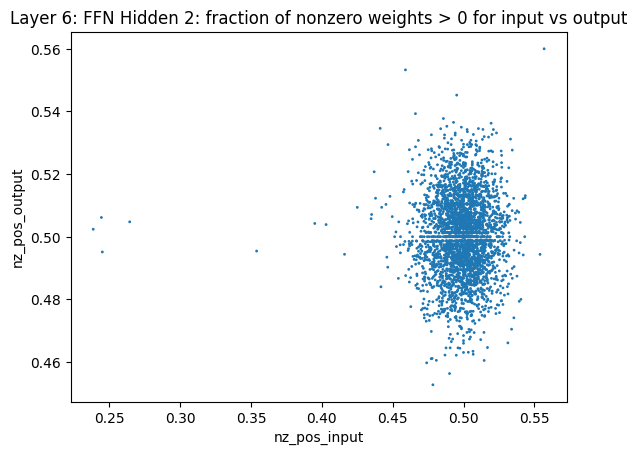

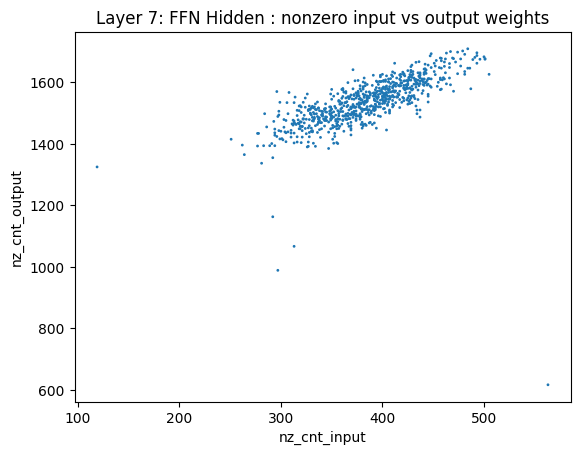

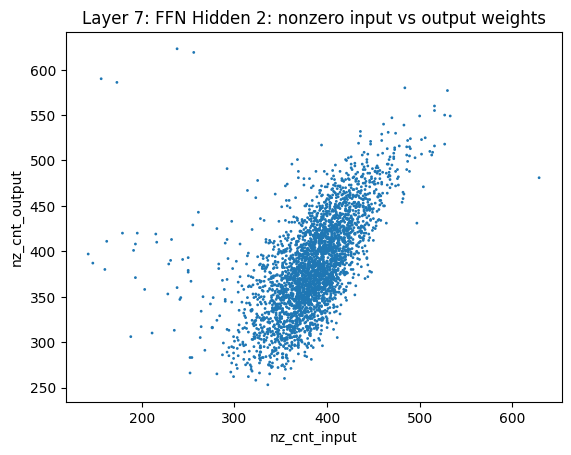

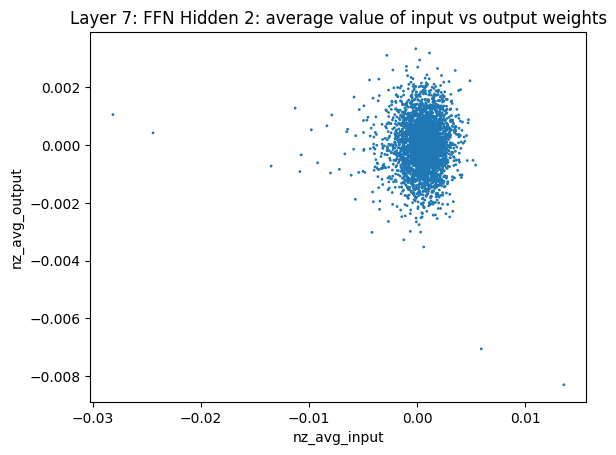

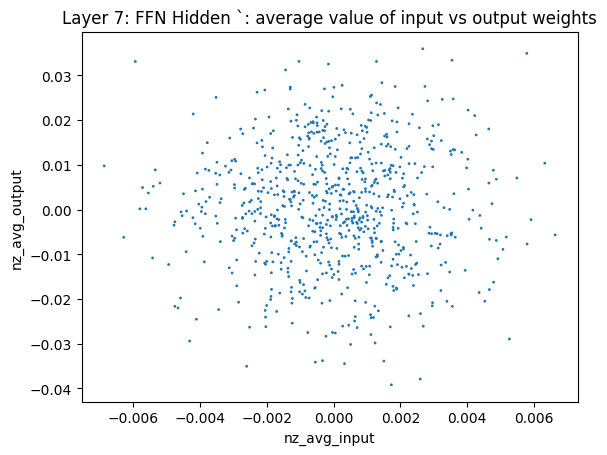

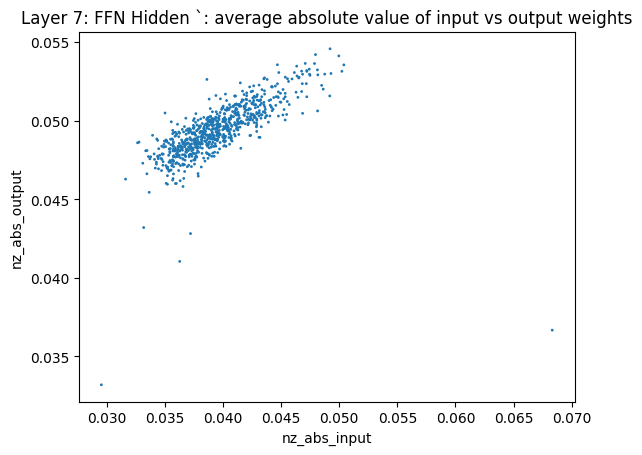

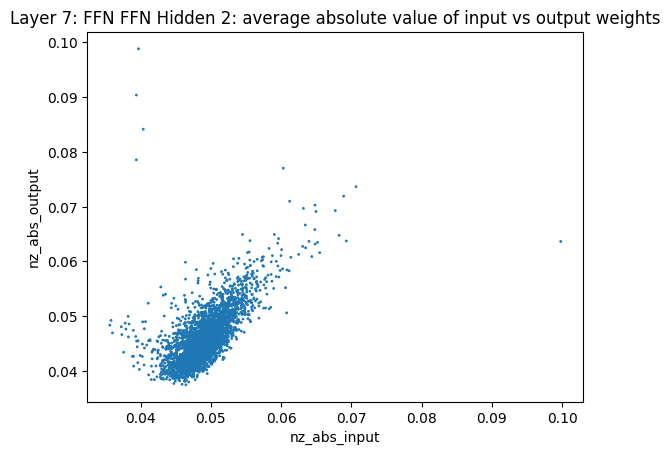

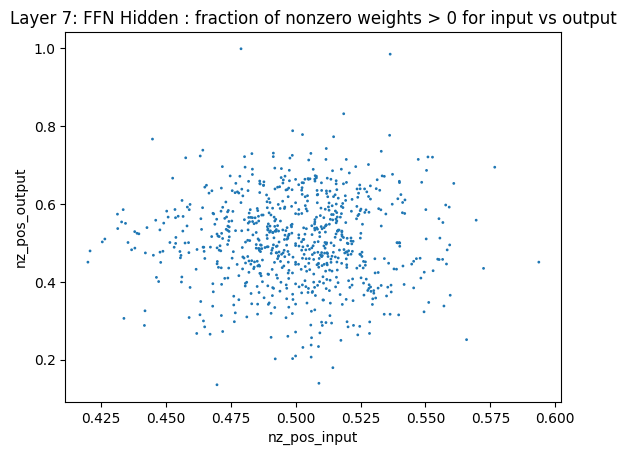

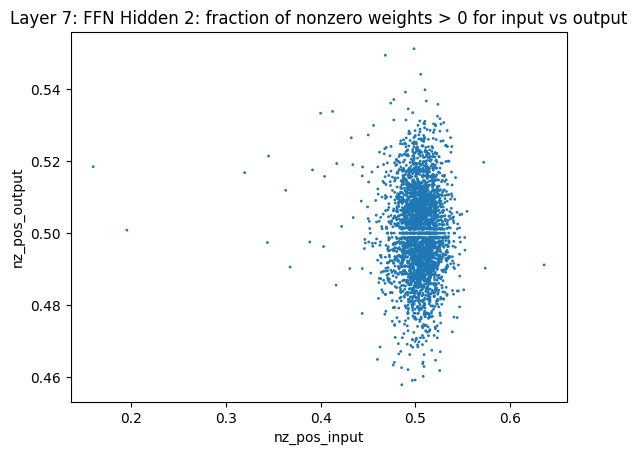

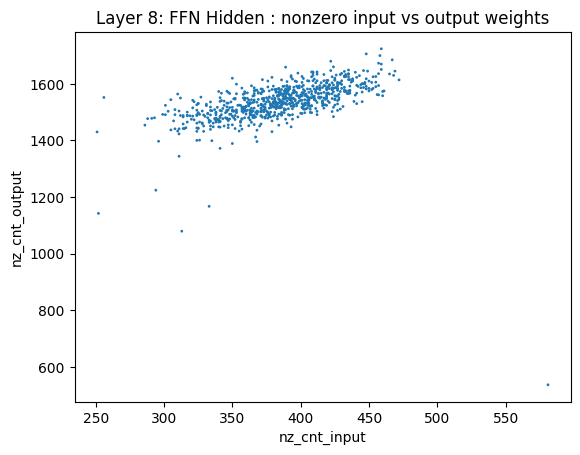

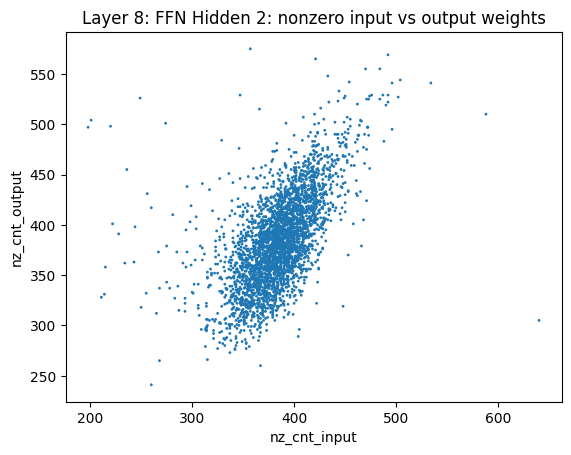

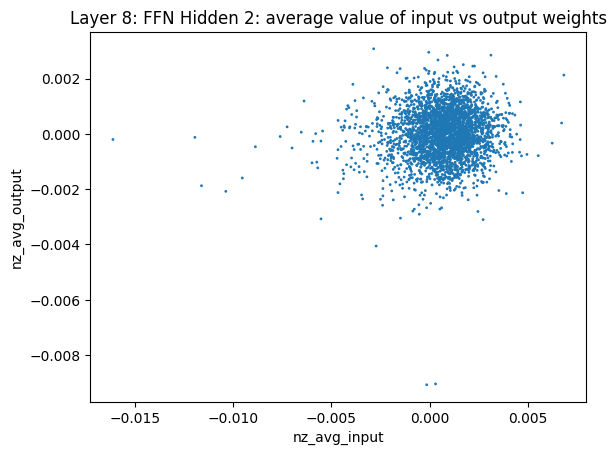

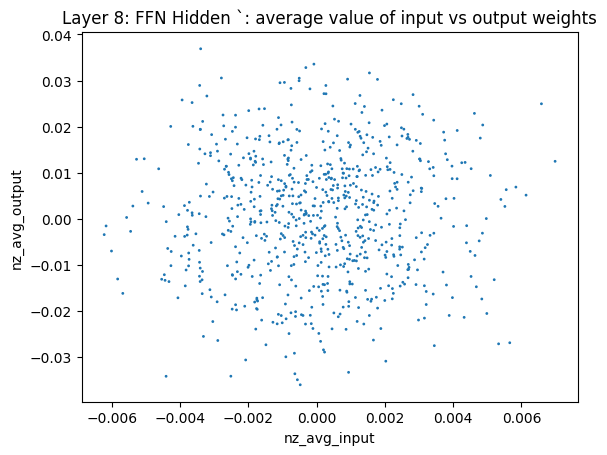

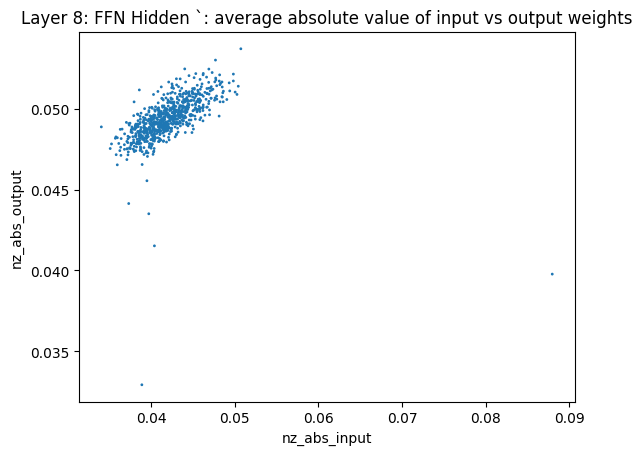

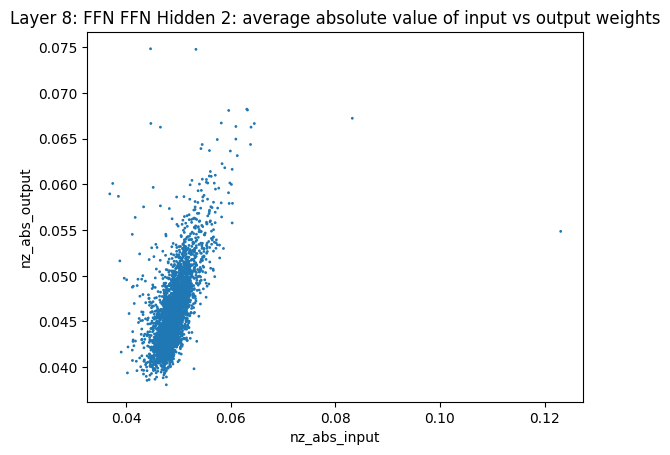

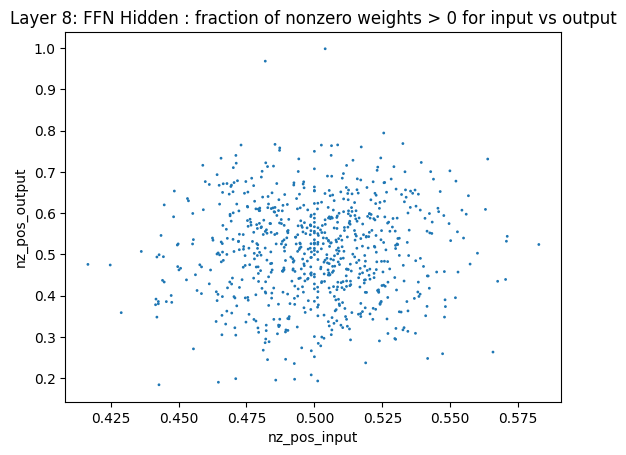

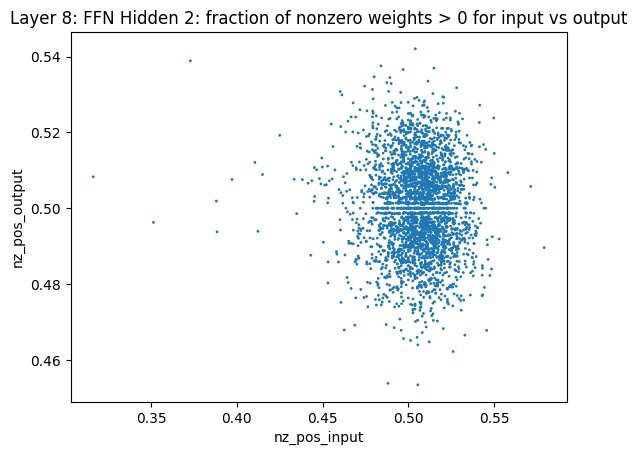

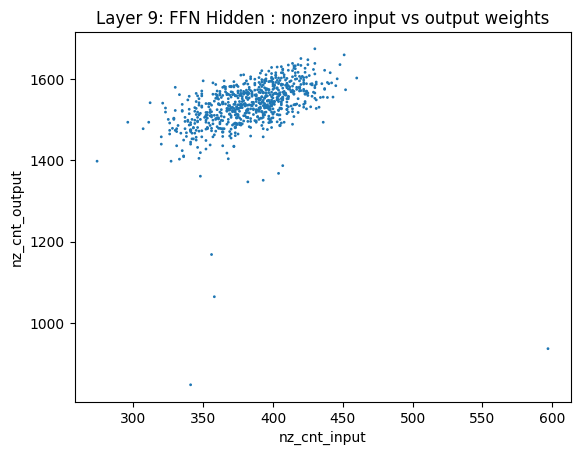

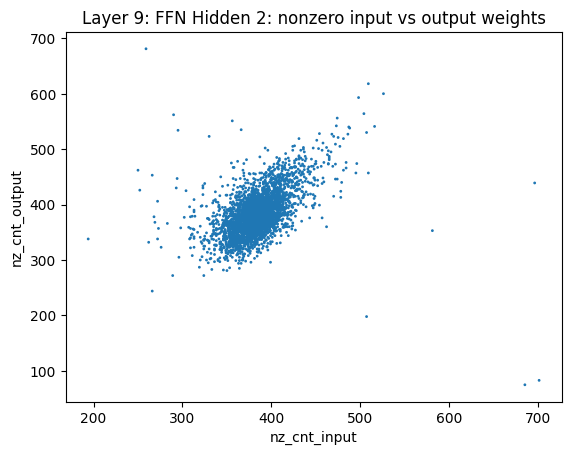

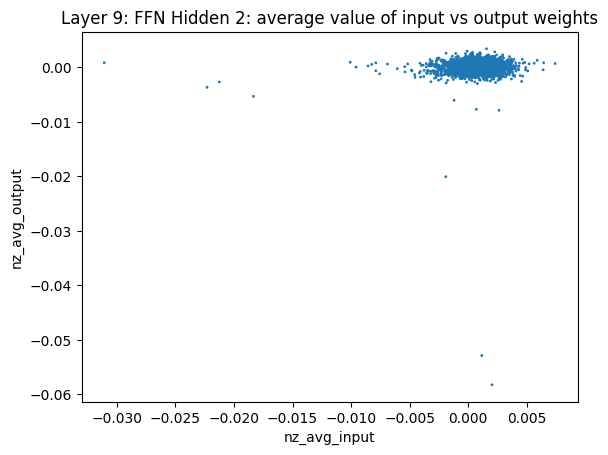

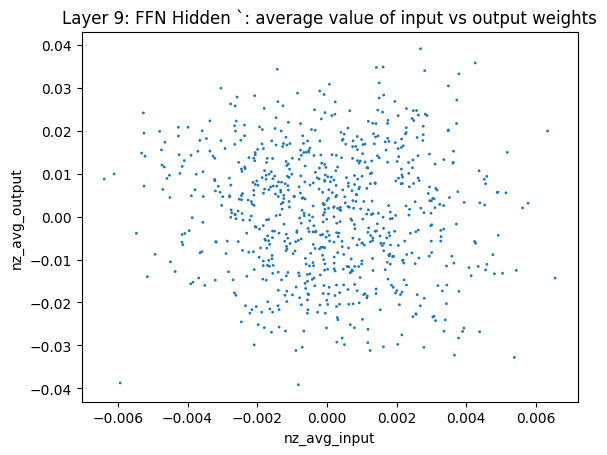

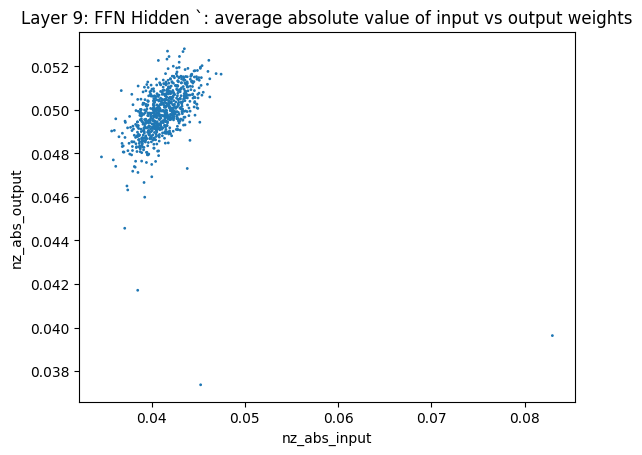

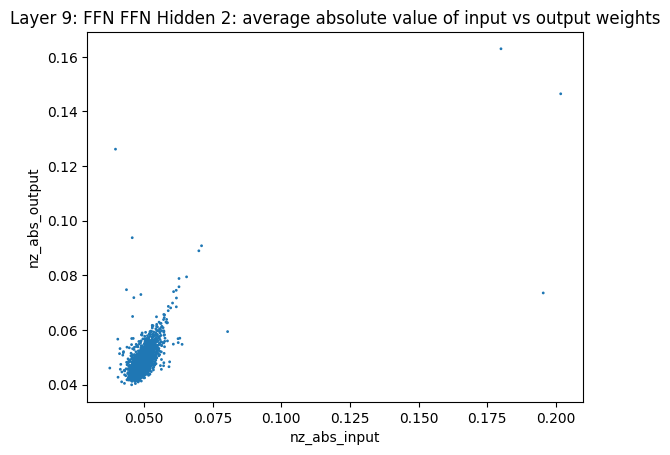

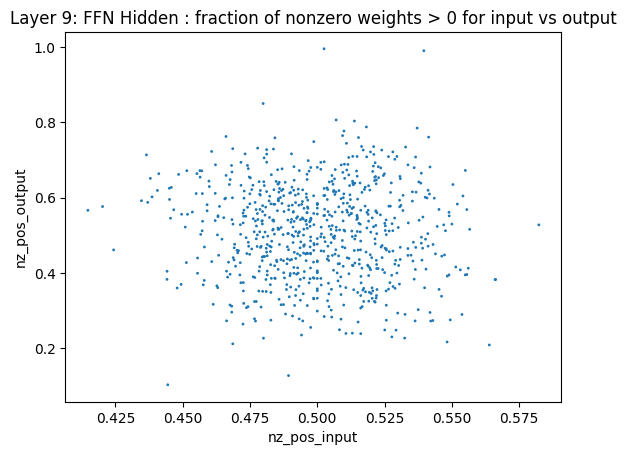

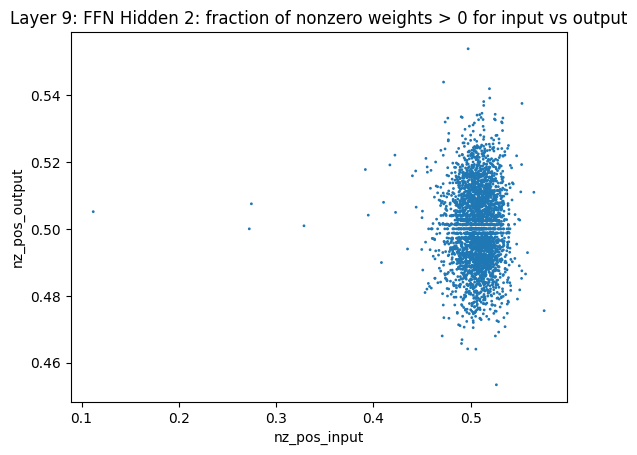

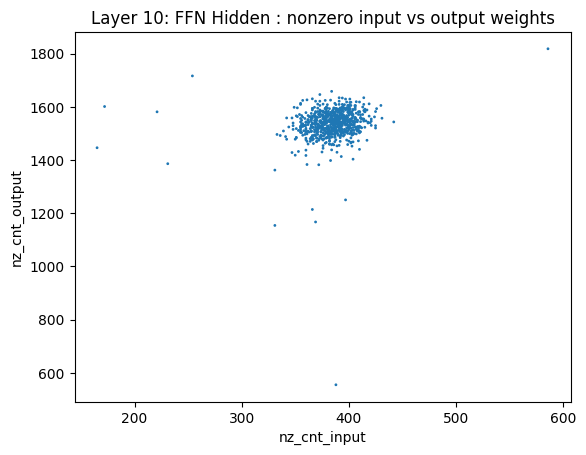

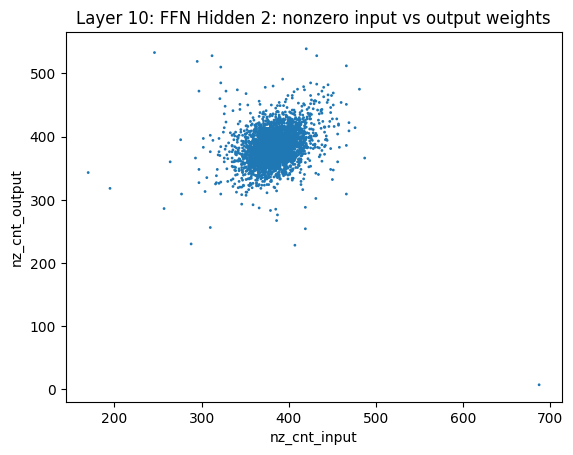

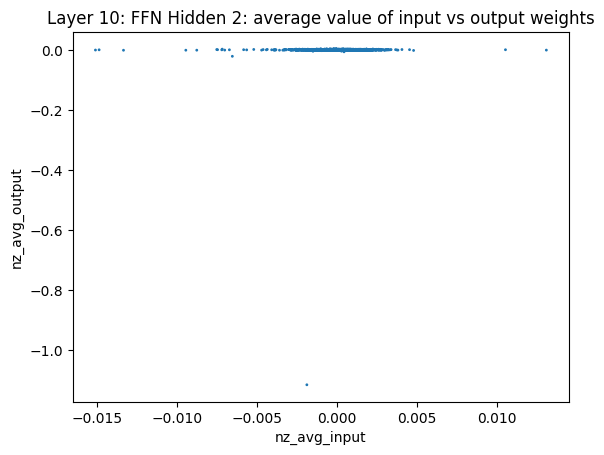

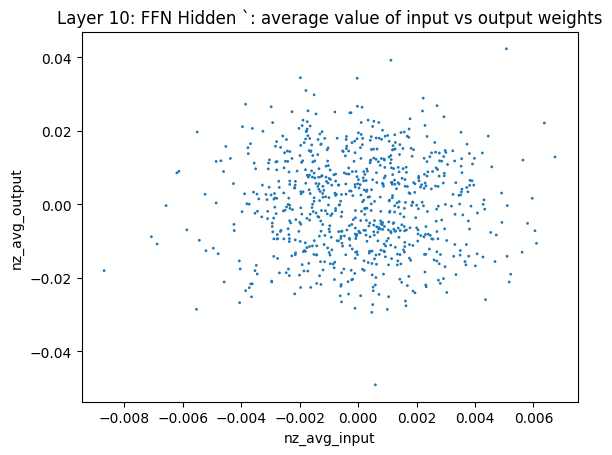

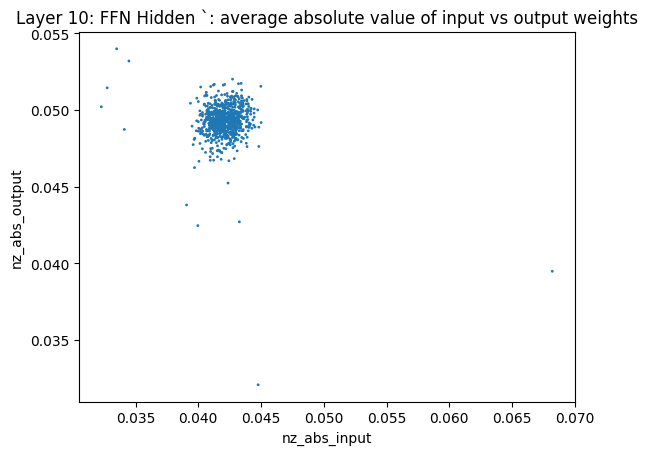

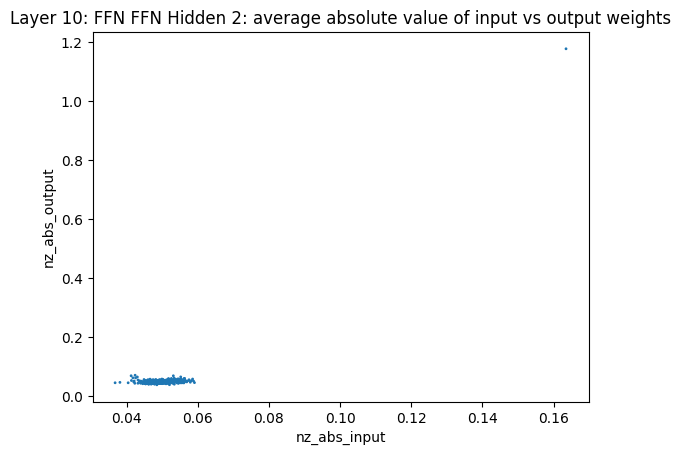

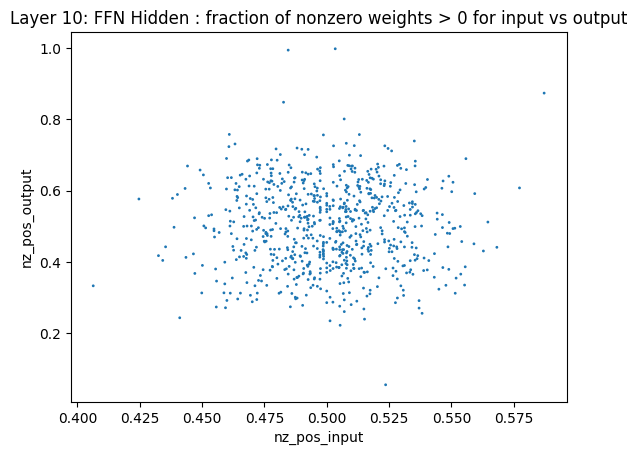

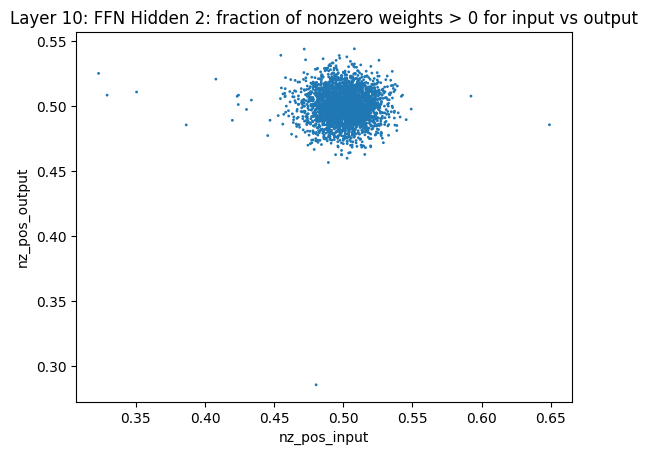

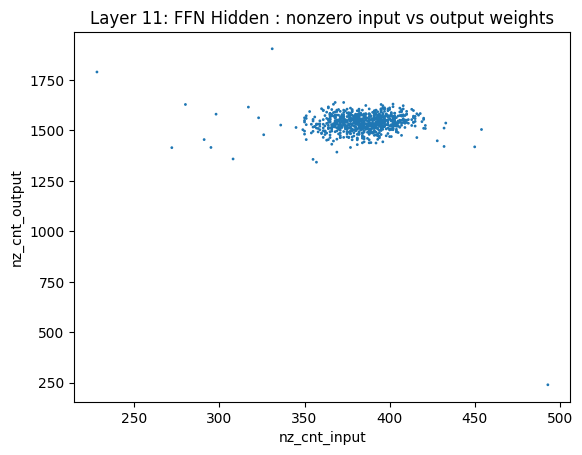

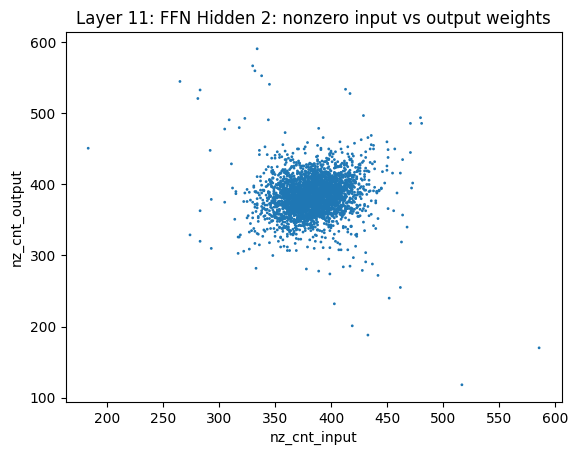

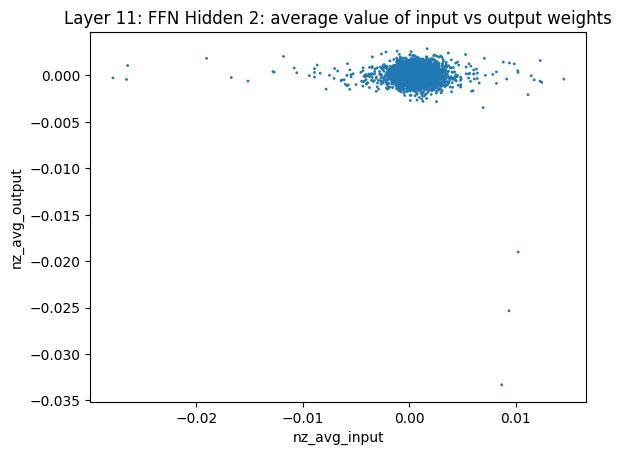

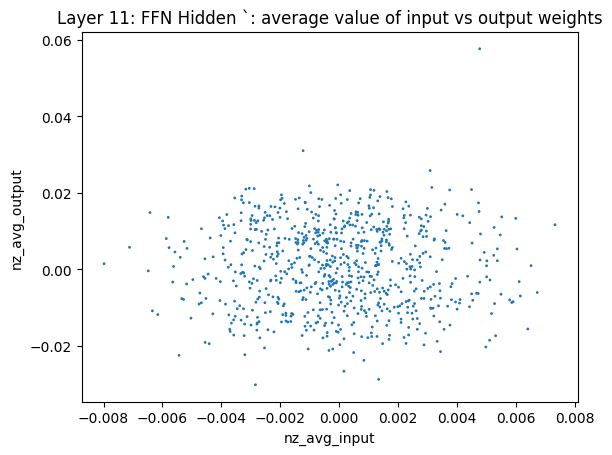

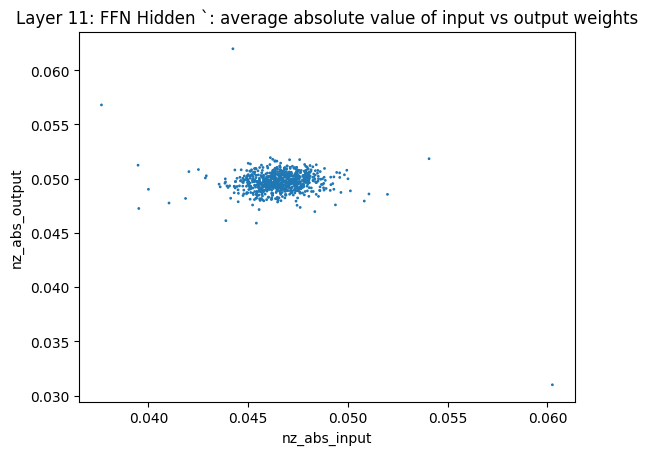

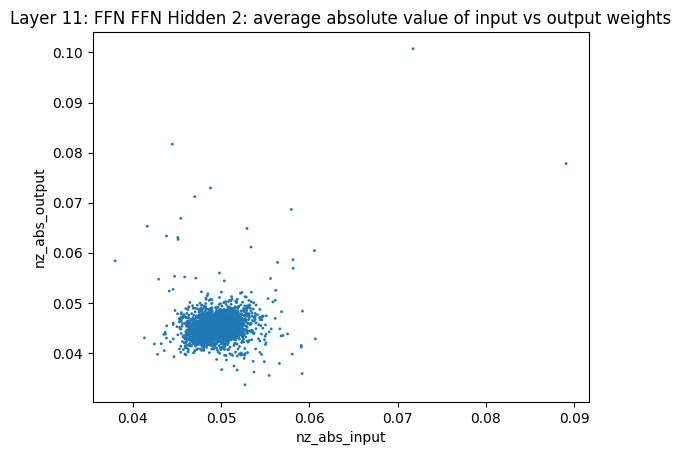

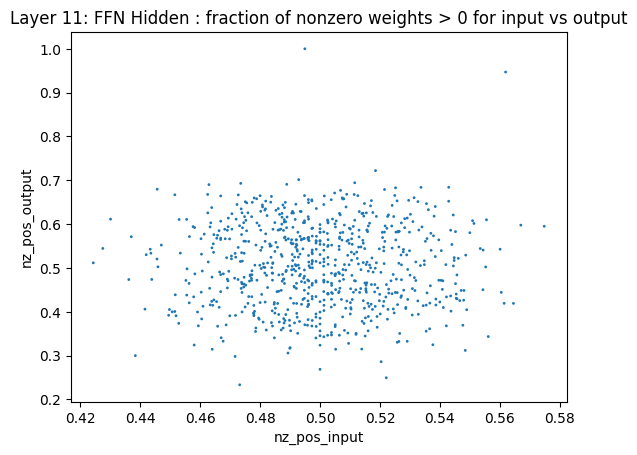

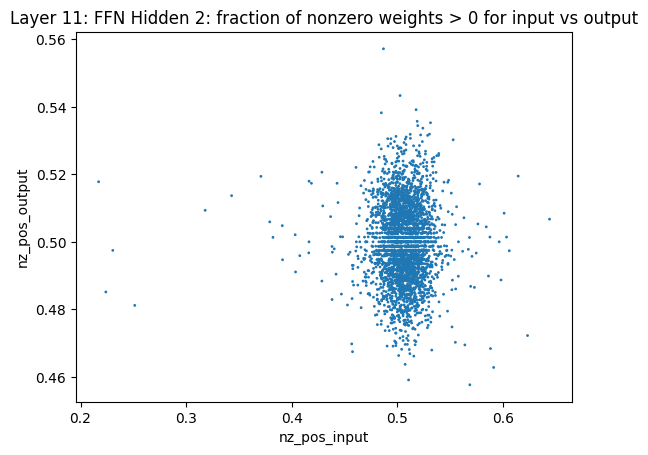

In [369]:
# Layer by layer analysis
ffn_corr1_df = df = pd.DataFrame({'nz_cnt_corr:': pd.Series(dtype='float'),
                   'nz_pos_corr': pd.Series(dtype='float'),
                   'nz_avg_corr': pd.Series(dtype='float'),
                   'nz_abs_corr:': pd.Series(dtype='float')})

ffn_corr2_df = df = pd.DataFrame({'nz_cnt_corr:': pd.Series(dtype='float'),
                   'nz_pos_corr': pd.Series(dtype='float'),
                   'nz_avg_corr': pd.Series(dtype='float'),
                   'nz_abs_corr:': pd.Series(dtype='float')})


raw_corr_df = pd.DataFrame(columns= ['layer_number','raw_q_k_corr', 'raw_q_v_corr', 'raw_k_v_corr'])

summ_attn_corr_colnames = ['layer_number','q_k_nonzero', 'q_v_nonzero','k_v_nonzero',
                      'q_k_positive', 'q_v_positive', 'k_v_positive',
                      'q_k_nz_avg', 'q_v_nz_avg', 'k_v_nz_avg', 'q_k_nz_abs_avg',
                      'q_v_nz_abs_avg', 'k_v_nz_abs_avg']
summ_attn_corr_in_df = pd.DataFrame(columns=summ_attn_corr_colnames)
summ_attn_corr_out_df = pd.DataFrame(columns=summ_attn_corr_colnames)

for layer_num in range(12):
    print(f"Feed-Forward Node Input/Output Correlations for layer {layer_num}:")
    rv_corr1, rv_corr2 = analyze_bert_ffn_layer(model, layer_num, PRUNE_AMT=0.5, PLOT_OPTION=True)
    ffn_corr1_df.loc[len(ffn_corr1_df)] = rv_corr1
    ffn_corr2_df.loc[len(ffn_corr2_df)] = rv_corr2
    
    raw, summ_in, summ_out = analyze_bert_self_attn_layer(model, layer_num)
    raw_corr_df = pd.concat([raw_corr_df,raw], ignore_index=True)
    summ_attn_corr_in_df = pd.concat([summ_attn_corr_in_df, pd.DataFrame(summ_in, index=[layer_num])],
                                    ignore_index=True) 
    summ_attn_corr_out_df = pd.concat([summ_attn_corr_out_df, pd.DataFrame(summ_out, index=[layer_num])],
                                    ignore_index=True)
    
    

    

<AxesSubplot: title={'center': 'Hidden Layer 1 (self-attention ffn output)'}, xlabel='Layer number', ylabel='Node-wise Input-Output Correlations'>

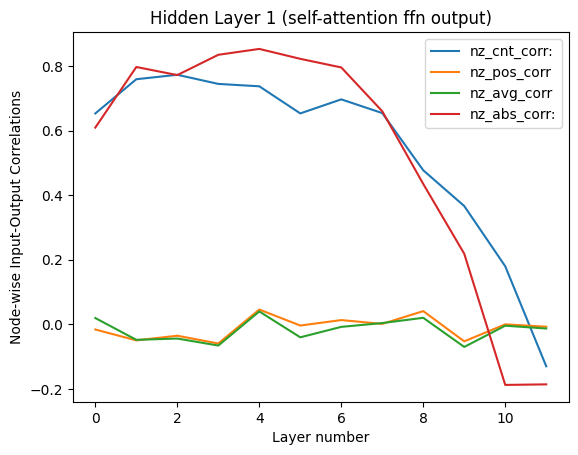

In [370]:
ffn_corr1_df.plot(xlabel="Layer number", ylabel= "Node-wise Input-Output Correlations",
             title="Hidden Layer 1 (self-attention ffn output)")

<AxesSubplot: title={'center': 'Hidden Layer 2 (intermediate dense ffn output)'}, xlabel='Layer number', ylabel='Node-wise Input-Output Correlations'>

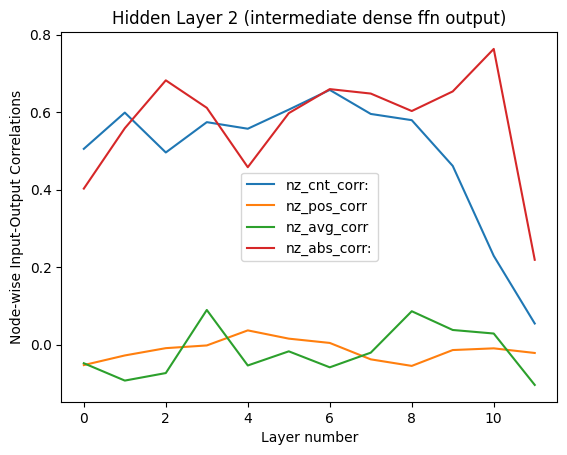

In [371]:
ffn_corr2_df.plot(xlabel="Layer number", ylabel= "Node-wise Input-Output Correlations",
             title="Hidden Layer 2 (intermediate dense ffn output)")

<AxesSubplot: title={'center': 'Element-wise correlations of self-attention weight matrices within layers'}, xlabel='Layer Number', ylabel='Correlation'>

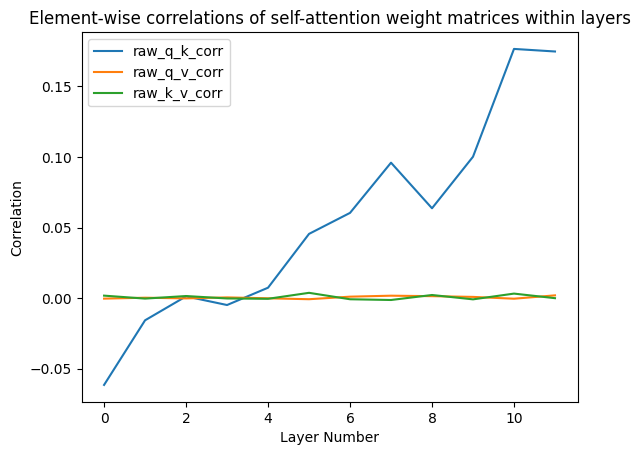

In [372]:
raw_corr_df[['raw_q_k_corr', 'raw_q_v_corr', 'raw_k_v_corr']].plot(xlabel="Layer Number",
                                                                    ylabel = "Correlation",
                                                                  title = "Element-wise correlations of self-attention weight matrices within layers")

<AxesSubplot: title={'center': 'Summary weight matrix columns correlations'}, xlabel='Layer number', ylabel='Correlation'>

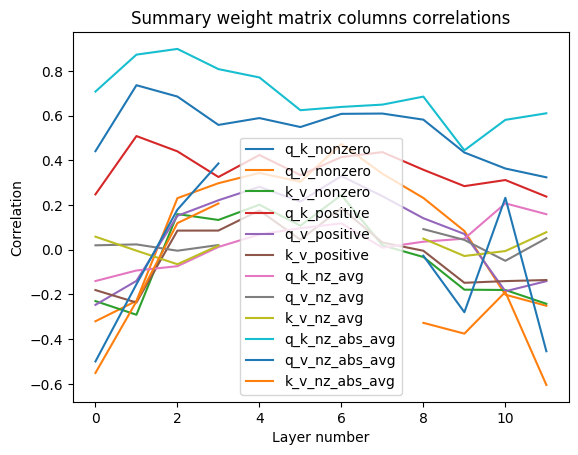

In [375]:
summ_attn_corr_in_df.loc[:, summ_attn_corr_in_df.columns!='layer_number'].plot(xlabel="Layer number", ylabel= "Correlation",
             title="Summary weight matrix columns correlations")

<AxesSubplot: title={'center': 'Summary weight matrix rows correlations'}, xlabel='Layer number', ylabel='Correlation'>

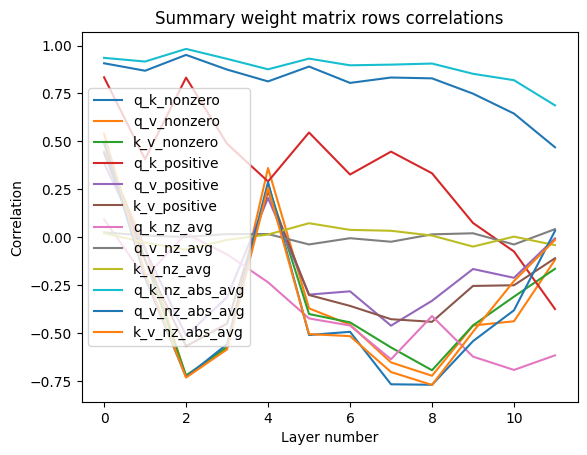

In [374]:
summ_attn_corr_out_df.loc[:, summ_attn_corr_out_df.columns!='layer_number'].plot(xlabel="Layer number", ylabel= "Correlation",
             title="Summary weight matrix rows correlations")

In [401]:
#raw_corr_df
raw

layer_number  raw_q_k_corr  raw_q_v_corr  raw_k_v_corr
0            11      0.185768      0.001923      0.000113

In [404]:
if "hh":
    print("hello")

hello


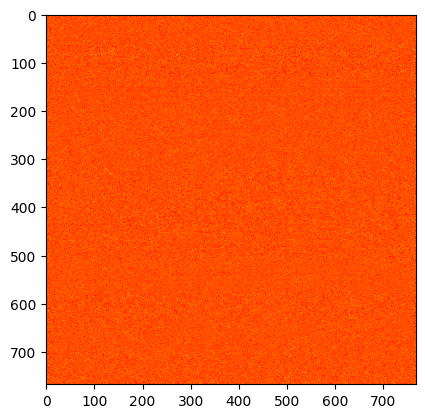

In [389]:
plt.imshow(model.encoder.layer[5].attention.self.query.weight.data.numpy(),
           cmap='hot')

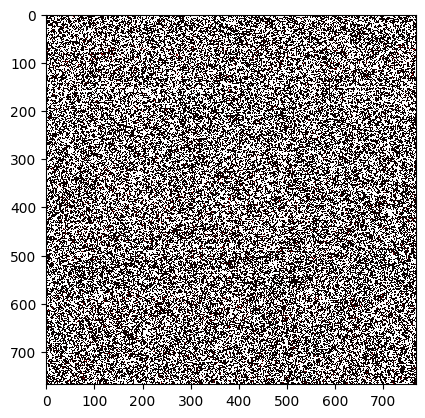

In [390]:
plt.imshow(model.encoder.layer[5].attention.self.query.weight.data.numpy(),
           cmap='hot', norm="log")

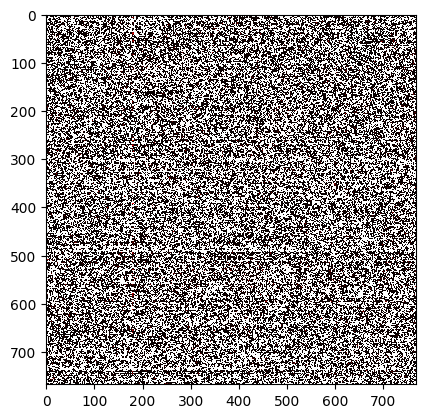

In [391]:
plt.imshow(model.encoder.layer[11].attention.self.query.weight.data.numpy(),
           cmap='hot', norm="log")

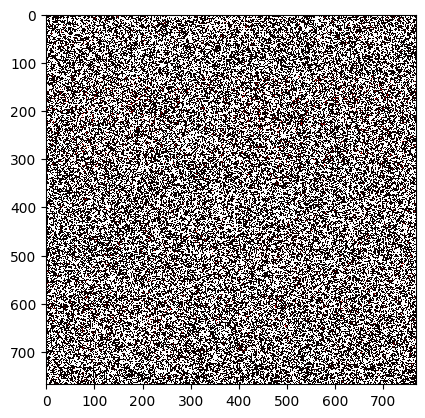

In [396]:
plt.imshow(model.encoder.layer[4].attention.self.value.weight.data.numpy(),
           cmap='hot', norm='log')

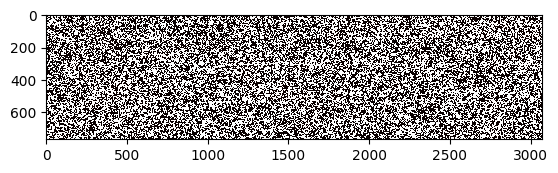

In [399]:
plt.imshow(model.encoder.layer[0].output.dense.weight.data.numpy(),
           cmap='hot', norm="log")